
# **A Comprehensive Evaluation of Fisher-Weighted Model Merging Methods**
---

## **Description of the Paper and Project**

#### **Paper Overview**
The paper examines the challenges and methodologies for merging neural network models trained on different datasets or with varying levels of noise. It provides an in-depth analysis of merging techniques, including:
- **Fisher-weighted averaging**: A method that incorporates the Fisher Information to merge models effectively, prioritizing parameters critical to the original training objective.
- **Isotropic merging**: A naive approach that averages model parameters directly.
- **Output ensembling**: A post-training technique that combines predictions from multiple models for improved robustness.

Additionally, the paper investigates the impact of noisy training on model performance and explores the behavior of merging models trained on divergent datasets (e.g., MNIST and Fashion-MNIST). Through extensive experiments, the paper evaluates these techniques based on metrics like accuracy, F1-score, and precision-recall balance.

#### **Project Description**
For this project, I implemented, extended, and evaluated the methodologies discussed in the paper. The work can be divided into several key components:

1. **Noisy Training Pipeline**:
   - Implemented a framework for training models with noise added to both inputs and labels. This allows studying the effect of noise on model performance and its implications for merging strategies.
   - Models trained with noise were compared against clean models to evaluate their robustness and behavior under merging.

2. **Model Merging Techniques**:
   - Developed a flexible pipeline to apply various merging strategies, including Fisher-weighted averaging, isotropic merging, and output ensembling.
   - Extended the merging framework to support scenarios involving models trained on divergent datasets (e.g., MNIST and Fashion-MNIST).

3. **Evaluation Metrics**:
   - Used metrics like accuracy, F1-score, precision, and recall to evaluate model performance before and after merging.
   - Visualized and compared results using bar charts and layer distribution plots, highlighting the trade-offs between merging methods.

4. **Experiments on Divergent Datasets**:
   - Evaluated the merging strategies for models trained on MNIST and Fashion-MNIST to understand how divergence affects the efficacy of merging.
   - Analyzed the performance of merged models on both datasets and provided insights into generalization.

5. **Ablation Study**:
   - Conducted experiments to assess the impact of noise levels, merging parameters (e.g., Fisher-weighted alpha), and dataset similarity on the performance of merging techniques.

#### **Key Contributions**
- Implemented a robust framework to evaluate merging techniques for neural networks.
- Developed pipelines for noisy training and merging models trained on divergent datasets.
- Provided a comprehensive evaluation of merging strategies under noisy and clean settings, highlighting the advantages and limitations of each approach.
- Delivered visualizations and summaries that make the results accessible and interpretable.

#### **Conclusion**
This project builds upon the methodologies proposed in the paper and extends them with new experiments and insights. The findings reinforce the importance of understanding dataset divergence, noise resilience, and merging strategies for practical applications of neural network merging.

# **Project Source Code**

## Libraries

In [4]:
# Core Python imports
import sys
import os
import copy
import argparse

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

# torchvision imports
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Visualization
import matplotlib.pyplot as plt

# Utilities
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Ensure proper logging and environment setup
os.environ["TORCH_DISTRIBUTED_DEBUG"] = "OFF"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

## Model

### Base Model

In [5]:
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()

    def forward(self, x):
        """
        Defines the forward pass of the model.
        Must be overridden by subclasses.
        """
        raise NotImplementedError("Subclasses must implement this method")

    def save(self, path):
        """
        Save the model's state_dict to the specified path.
        """
        torch.save(self.state_dict(), path)

    def load(self, path, device="cpu"):
        """
        Load the model's state_dict from the specified path.
        """
        self.load_state_dict(torch.load(path, map_location=device))
        self.eval()  # Set model to evaluation mode

    def initialize_weights(self):
        """
        Optional: Initialize weights for the model. Override this if needed.
        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

### MINST Models

In [6]:
class MNISTMLP(BaseModel):
    def __init__(self):
        super(MNISTMLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        return nn.LogSoftmax(dim=1)(self.fc3(x))


class MNISTCNN(BaseModel):
    def __init__(self):
        super(MNISTCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.MaxPool2d(2)(x)
        x = nn.ReLU()(self.conv2(x))
        x = nn.MaxPool2d(2)(x)
        x = x.view(-1, 64 * 7 * 7)
        x = nn.ReLU()(self.fc1(x))
        return nn.LogSoftmax(dim=1)(self.fc2(x))

### CIFAR-10 Models

In [8]:
class CIFAR10ResNet(BaseModel):
    def __init__(self):
        super(CIFAR10ResNet, self).__init__()
        self.resnet = models.resnet18(num_classes=10)

    def forward(self, x):
        return self.resnet(x)

class CIFAR10VGG(BaseModel):
    def __init__(self):
        super(CIFAR10VGG, self).__init__()
        self.vgg = models.vgg16(num_classes=10)

    def forward(self, x):
        return self.vgg(x)

## Merging Methods

### Isotropic merging

In [9]:
class NaiveMerging:
    @staticmethod
    def merge_models(model1, model2, alpha=0.5):
        """
        Naive isotropic merging of two models by averaging their parameters.

        :param model1: The first model.
        :param model2: The second model.
        :param alpha: Weight for model1 (default: 0.5).
        :return: A new merged model.
        """
        # Create a deep copy of model1 to avoid modifying it directly
        merged_model = copy.deepcopy(model1)

        # Ensure both models are on the same device
        device = next(model1.parameters()).device
        model2.to(device)
        merged_model.to(device)

        # Merge parameters
        for (name1, param1), (name2, param2) in zip(model1.named_parameters(), model2.named_parameters()):
            if name1 == name2:
                merged_param = alpha * param1.data + (1 - alpha) * param2.data
                merged_model.state_dict()[name1].copy_(merged_param)

        return merged_model

### OutputEnsembling Merging

In [10]:
class OutputEnsembling:
    @staticmethod
    def merge_models(model1, model2):
        """
        Create an ensemble model that averages the predictions of model1 and model2.

        :param model1: The first model.
        :param model2: The second model.
        :return: A merged ensemble model.
        """

        class MergedEnsembleModel(nn.Module):
            def __init__(self, model1, model2):
                super(MergedEnsembleModel, self).__init__()
                self.model1 = model1
                self.model2 = model2

            def forward(self, x):
                # Forward pass through both models and average the predictions
                output1 = self.model1(x)
                output2 = self.model2(x)
                return (output1 + output2) / 2.0

        # Ensure models are on the same device
        device = next(model1.parameters()).device
        model2.to(device)

        # Create and return the ensembled model
        merged_model = MergedEnsembleModel(model1, model2)
        return merged_model

### Fisher Merging

In [11]:
class FisherWeightedAveraging:
    @staticmethod
    def compute_fisher_information(model, data_loader, criterion):
        """
        Compute Fisher Information for a given model and dataset.

        :param model: The model for which Fisher information is computed.
        :param data_loader: DataLoader providing the dataset.
        :param criterion: Loss function used for backpropagation.
        :return: A dictionary containing the Fisher information for each parameter.
        """
        fisher_matrix = {}
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        model.eval()

        for data, target in tqdm(data_loader, desc="Computing Fisher Information", unit="batch"):
            data, target = data.to(device), target.to(device)
            model.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()

            for name, param in model.named_parameters():
                if param.grad is not None:
                    if name not in fisher_matrix:
                        fisher_matrix[name] = param.grad.data.clone().pow(2)
                    else:
                        fisher_matrix[name] += param.grad.data.clone().pow(2)

        for name in fisher_matrix:
            fisher_matrix[name] /= len(data_loader)

        return fisher_matrix

    @staticmethod
    def merge_models(
            model1,
            model2,
            fisher1,
            fisher2,
            alpha=0.5,
            uniform_weights=False,
            layer_wise_fisher=None,
            fisher_scaling=1.0
    ):
        """
        Merge two models using Fisher-weighted averaging with various options.

        :param model1: The first model to merge.
        :param model2: The second model to merge.
        :param fisher1: Fisher information for the first model.
        :param fisher2: Fisher information for the second model.
        :param alpha: Balancing factor for averaging (default: 0.5).
        :param uniform_weights: If True, disables Fisher weighting (uses uniform weights).
        :param layer_wise_fisher: List of layers to apply Fisher merging; isotropic merging for others.
        :param fisher_scaling: Scaling factor to apply to Fisher Information.
        :return: The merged model.
        """
        merged_model = copy.deepcopy(model1)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        merged_model.to(device)
        model2.to(device)

        epsilon = 1e-8

        for (name1, param1), (name2, param2) in tqdm(
                zip(merged_model.named_parameters(), model2.named_parameters()),
                desc="Merging Models",
                unit="param"
        ):
            if name1 == name2:
                if uniform_weights or (layer_wise_fisher and name1 not in layer_wise_fisher):
                    # Use naive isotropic merging for uniform weights or excluded layers
                    merged_param = alpha * param1.data + (1 - alpha) * param2.data
                else:
                    # Apply Fisher weighting with optional scaling
                    weight1 = fisher_scaling * fisher1.get(name1, torch.ones_like(param1.data)).to(device)
                    weight2 = fisher_scaling * fisher2.get(name1, torch.ones_like(param2.data)).to(device)

                    total_weight = weight1 + weight2 + epsilon
                    merged_param = (alpha * weight1 * param1.data + (1 - alpha) * weight2 * param2.data) / total_weight

                param1.data.copy_(merged_param)

        return merged_model

    @staticmethod
    def validate_model(model, data_loader, criterion):
        """
        Validate a model on a dataset and compute metrics.

        :param model: The model to validate.
        :param data_loader: DataLoader providing the validation dataset.
        :param criterion: Loss function used for evaluation.
        :return: A dictionary containing evaluation metrics: accuracy, F1-score, precision, recall, and loss.
        """
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        model.eval()

        all_targets = []
        all_predictions = []
        total_loss = 0.0

        with torch.no_grad():
            for data, target in tqdm(data_loader, desc="Validating Model", unit="batch"):
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)
                total_loss += loss.item()

                _, predictions = torch.max(output, dim=1)
                all_targets.extend(target.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())

        accuracy = accuracy_score(all_targets, all_predictions)
        f1 = f1_score(all_targets, all_predictions, average='weighted')
        precision = precision_score(all_targets, all_predictions, average='weighted')
        recall = recall_score(all_targets, all_predictions, average='weighted')

        return {
            "loss": total_loss / len(data_loader),
            "accuracy": accuracy,
            "f1_score": f1,
            "precision": precision,
            "recall": recall
        }


## Training Class

In [12]:
class TrainingPipeline:
    def __init__(self, model, train_loader, test_loader, device=None, optimizer_params=None):
        """
        Initialize the TrainingPipeline.

        :param model: The model to train and evaluate.
        :param train_loader: DataLoader for the training dataset.
        :param test_loader: DataLoader for the test dataset.
        :param device: The device to use (default: automatically selects "cuda" if available).
        :param optimizer_params: Dictionary of optimizer parameters (e.g., {"lr": 0.01, "weight_decay": 1e-5}).
        """
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion = nn.CrossEntropyLoss()

        # If optimizer_params is provided, use them; otherwise, use default Adam optimizer
        if optimizer_params:
            self.optimizer = optim.Adam(self.model.parameters(), **optimizer_params)
        else:
            self.optimizer = optim.Adam(self.model.parameters())

    def train(self, epochs=10):
        """
        Train the model.

        :param epochs: Number of training epochs (default: 10).
        """
        print(f"Training on {self.device}...")
        for epoch in range(epochs):
            self.model.train()
            total_loss = 0
            for data, target in self.train_loader:
                data, target = data.to(self.device), target.to(self.device)
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(self.train_loader)}")

        # After training, move the model to CPU
        self.model.cpu()
        print("Training complete. Model moved to CPU.")

    def test(self):
        """
        Evaluate the model on the test dataset.
        """
        # Ensure the model is on the same device as the evaluation data
        self.model.to(self.device)
        self.model.eval()

        correct = 0
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / len(self.test_loader.dataset) * 100
        print(f"Test Accuracy: {accuracy:.2f}%")
        return accuracy


## Utility Function

### Figures

In [13]:
def draw_comparison_chart(isotropic_results, ensemble_results, fisher_results):
    """
    Generate comparison charts for each dataset or a single dataset based on the validation results
    of isotropic merging, Fisher merging, and output ensembling.

    :param isotropic_results: Dictionary containing validation metrics for isotropic merging.
    :param ensemble_results: Dictionary containing validation metrics for output ensembling.
    :param fisher_results: Dictionary containing validation metrics for Fisher merging.
    """
    # Check if the results are for a single dataset or multiple datasets
    is_single_dataset = isinstance(isotropic_results, dict) and 'accuracy' in isotropic_results

    if is_single_dataset:
        # Handle single dataset case
        print("Generating comparison charts for a single dataset...")

        # Extract accuracy and F1-score
        accuracies = [
            isotropic_results['accuracy'] * 100,
            fisher_results['accuracy'] * 100,
            ensemble_results['accuracy'] * 100
        ]
        f1_scores = [
            isotropic_results['f1_score'] * 100,
            fisher_results['f1_score'] * 100,
            ensemble_results['f1_score'] * 100
        ]

        # Define labels for the methods
        methods = ["Isotropic Merging", "Fisher Merging", "Output Ensembling"]

        # Plot accuracy comparison
        plt.figure(figsize=(10, 5))
        plt.bar(methods, accuracies, color=["orange", "blue", "green"])
        plt.ylim(0, 100)
        plt.ylabel("Accuracy (%)")
        plt.title("Comparison of Merging Methods: Accuracy")
        plt.show()

        # Plot F1-score comparison
        plt.figure(figsize=(10, 5))
        plt.bar(methods, f1_scores, color=["orange", "blue", "green"])
        plt.ylim(0, 100)
        plt.ylabel("F1-Score (%)")
        plt.title("Comparison of Merging Methods: F1-Score")
        plt.show()
    else:
        # Handle multiple datasets case
        print("Generating comparison charts for multiple datasets...")
        dataset_names = isotropic_results.keys()

        for dataset in dataset_names:
            print(f"Generating comparison charts for {dataset}...")

            # Extract accuracy and F1-score for the current dataset
            accuracies = [
                isotropic_results[dataset]['accuracy'] * 100,
                fisher_results[dataset]['accuracy'] * 100,
                ensemble_results[dataset]['accuracy'] * 100
            ]
            f1_scores = [
                isotropic_results[dataset]['f1_score'] * 100,
                fisher_results[dataset]['f1_score'] * 100,
                ensemble_results[dataset]['f1_score'] * 100
            ]

            # Define labels for the methods
            methods = ["Isotropic Merging", "Fisher Merging", "Output Ensembling"]

            # Plot accuracy comparison for the current dataset
            plt.figure(figsize=(10, 5))
            plt.bar(methods, accuracies, color=["orange", "blue", "green"])
            plt.ylim(0, 100)
            plt.ylabel("Accuracy (%)")
            plt.title(f"Comparison of Merging Methods: Accuracy ({dataset})")
            plt.show()

            # Plot F1-score comparison for the current dataset
            plt.figure(figsize=(10, 5))
            plt.bar(methods, f1_scores, color=["orange", "blue", "green"])
            plt.ylim(0, 100)
            plt.ylabel("F1-Score (%)")
            plt.title(f"Comparison of Merging Methods: F1-Score ({dataset})")
            plt.show()


def plot_layer_distributions_with_stats(models, layer_names, model_labels):
    """
    Plot the weight distributions for specific layers across multiple models in a grid layout,
    with statistics (mean, std, min, max) displayed on each plot.

    :param models: List of models to visualize (e.g., [model1, model2, isotropic_model, fisher_merged_model]).
    :param layer_names: List of layer names (keys from state_dict) to plot.
    :param model_labels: List of labels corresponding to each model.
    """
    # Ensure input lists are consistent
    assert len(models) == len(model_labels), "Each model must have a corresponding label."

    num_layers = len(layer_names)
    num_models = len(models)

    # Create subplots
    fig, axes = plt.subplots(num_layers, num_models, figsize=(4 * num_models, 4 * num_layers), sharey=True)
    axes = axes if num_layers > 1 else [axes]  # Ensure axes is always 2D

    for i, layer_name in enumerate(layer_names):
        for j, (model, label) in enumerate(zip(models, model_labels)):
            ax = axes[i][j] if num_layers > 1 else axes[j]

            # Extract weights for the specified layer
            state_dict = model.state_dict()
            if layer_name in state_dict:
                weights = state_dict[layer_name].flatten().cpu().numpy()
                mean_val = weights.mean()
                std_val = weights.std()
                min_val = weights.min()
                max_val = weights.max()

                # Plot histogram
                ax.hist(weights, bins=50, alpha=0.6, color="blue")
                ax.set_title(f"{label} ({layer_name})", fontsize=10)
                ax.set_xlabel("Weight Values", fontsize=8)
                ax.set_ylabel("Frequency", fontsize=8)

                # Add statistics as text on the plot
                stats_text = f"Mean: {mean_val:.4f}\nStd: {std_val:.4f}\nMin: {min_val:.4f}\nMax: {max_val:.4f}"
                ax.text(0.95, 0.95, stats_text, fontsize=8, transform=ax.transAxes,
                        verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="round", alpha=0.3))
            else:
                # If layer not found, display a message
                ax.text(0.5, 0.5, f"Layer {layer_name} not found", ha='center', va='center')
                ax.set_title(f"{label} ({layer_name})")
                ax.axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show(block=True)

def validate_model(model, data_loader, criterion):
    """
    Validate a model on a dataset or multiple datasets and compute metrics.

    :param model: The model to validate.
    :param data_loader: DataLoader or a dictionary of DataLoaders for validation datasets.
    :param criterion: Loss function used for evaluation.
    :return: A dictionary containing evaluation metrics for each dataset:
             {dataset_name: {"accuracy", "f1_score", "precision", "recall", "loss"}}.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    def _validate_single(data_loader):
        """
        Validate the model on a single dataset.

        :param data_loader: DataLoader for the dataset.
        :return: Dictionary with evaluation metrics.
        """
        all_targets = []
        all_predictions = []
        total_loss = 0.0

        with torch.no_grad():
            for data, target in tqdm(data_loader, desc="Validating Model", unit="batch"):
                # Move data and target to the appropriate device
                data, target = data.to(device), target.to(device)

                # Forward pass
                output = model(data)
                loss = criterion(output, target)
                total_loss += loss.item()

                # Convert logits to predictions
                _, predictions = torch.max(output, dim=1)

                # Collect predictions and targets for metric calculation
                all_targets.extend(target.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())

        # Calculate metrics
        accuracy = accuracy_score(all_targets, all_predictions)
        f1 = f1_score(all_targets, all_predictions, average='weighted')
        precision = precision_score(all_targets, all_predictions, average='weighted')
        recall = recall_score(all_targets, all_predictions, average='weighted')

        return {
            "loss": total_loss / len(data_loader),
            "accuracy": accuracy,
            "f1_score": f1,
            "precision": precision,
            "recall": recall
        }

    # Handle single DataLoader or dictionary of DataLoaders
    if isinstance(data_loader, dict):
        results = {}
        for dataset_name, loader in data_loader.items():
            print(f"Validating on {dataset_name} dataset...")
            results[dataset_name] = _validate_single(loader)
        return results
    else:
        # Single dataset
        return _validate_single(data_loader)

### DatasetLoader

In [14]:
class DatasetLoader:
    @staticmethod
    def load_mnist(batch_size=64):
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        train_set = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
        test_set = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
        return (
            DataLoader(train_set, batch_size=batch_size, shuffle=True),
            DataLoader(test_set, batch_size=batch_size, shuffle=False),
        )

    @staticmethod
    def load_cifar10(batch_size=64, downsample=True):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        train_set = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
        test_set = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

        if downsample:
            # Downsample dataset by 50%
            train_set = Subset(train_set, indices=torch.arange(0, len(train_set) // 2))
            test_set = Subset(test_set, indices=torch.arange(0, len(test_set) // 2))

        return (
            DataLoader(train_set, batch_size=batch_size, shuffle=True),
            DataLoader(test_set, batch_size=batch_size, shuffle=False),
        )

    @staticmethod
    def load_fashion_mnist(batch_size=64):
        """
        Load the Fashion-MNIST dataset with transformations.

        :param batch_size: Batch size for the DataLoader.
        :return: Tuple of DataLoader instances for train and test datasets.
        """
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
        train_set = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
        test_set = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
        return (
            DataLoader(train_set, batch_size=batch_size, shuffle=True),
            DataLoader(test_set, batch_size=batch_size, shuffle=False),
        )


### ModelIO

In [15]:
class ModelIO:
    # Default folder for saving and loading models
    MODEL_DIR = "saved_models"

    @staticmethod
    def save_model(model, filename):
        """
        Save the model's state_dict to the specified path inside the default model directory.

        :param model: The model instance to save.
        :param filename: The filename for saving the model.
        """
        # Ensure the default directory exists
        os.makedirs(ModelIO.MODEL_DIR, exist_ok=True)

        # Build the full path
        path = os.path.join(ModelIO.MODEL_DIR, filename)

        # Save the model state_dict
        torch.save(model.state_dict(), path)
        print(f"Model saved at: {path}")

    @staticmethod
    def load_model(model, filename, device="cpu"):
        """
        Load the model's state_dict from the specified file in the default model directory.

        :param model: The model instance to load weights into.
        :param filename: The filename of the saved model weights.
        :param device: The device to load the model on ('cpu' or 'cuda').
        :return: The model with loaded weights.
        """
        # Build the full path
        path = os.path.join(ModelIO.MODEL_DIR, filename)

        # Check if the file exists
        if not os.path.exists(path):
            raise FileNotFoundError(f"Model file not found: {path}")

        # Load weights-only mode for safer deserialization
        model.load_state_dict(torch.load(path, map_location=device))
        model.to(device)
        print(f"Model loaded from: {path}")
        return model


### Noisy Models Functions

In [16]:
def noise_augmentation(data, noise_factor=0.2):
    """
    Add random noise to input data.

    :param data: Input data (e.g., images).
    :param noise_factor: Factor to scale the added noise.
    :return: Noisy data.
    """
    noisy_data = data + noise_factor * torch.randn_like(data)
    noisy_data = torch.clamp(noisy_data, 0.0, 1.0)  # Ensure data remains in valid range
    return noisy_data


def add_label_noise(labels, num_classes, noise_ratio=0.1):
    """
    Add noise to labels by randomly flipping some labels.

    :param labels: Original labels.
    :param num_classes: Number of classes.
    :param noise_ratio: Proportion of labels to randomize.
    :return: Labels with noise added.
    """
    noisy_labels = labels.clone()
    num_noisy = int(noise_ratio * len(labels))
    noisy_indices = torch.randperm(len(labels))[:num_noisy]
    noisy_labels[noisy_indices] = torch.randint(0, num_classes, (len(noisy_indices),))
    return noisy_labels

### Fisher Scaling Experiment

In [17]:
def fisher_scaling_experiment(test_loader, model1, model2, fisher1, fisher2, criterion, scaling_factors, weighting, layers):
    """
    Experiment with different scaling factors for Fisher Information during merging.

    :param test_loader: DataLoader for the test dataset.
    :param model1: The first pre-trained model.
    :param model2: The second pre-trained model.
    :param fisher1: Fisher information for the first model.
    :param fisher2: Fisher information for the second model.
    :param criterion: Loss function for evaluation.
    :param scaling_factors: A list of scaling factors
    :return: The scaling factor with the highest accuracy and its corresponding accuracy.
    """
    accuracies = []

    print("Running Fisher Scaling Experiment...")
    for beta in scaling_factors:
        print(f"Testing Fisher Scaling Factor β = {beta}...")
        merged_model = FisherWeightedAveraging.merge_models(
            model1, model2, fisher1, fisher2,
            fisher_scaling=beta, uniform_weights=weighting, layer_wise_fisher=layers
        )

        # Evaluate the merged model
        results = validate_model(merged_model, test_loader, criterion)
        print(f"Accuracy for β = {beta}: {results['accuracy']:.4f}")
        accuracies.append(results['accuracy'])

    # Find the scaling factor with the highest accuracy
    max_accuracy = max(accuracies)
    best_scaling_factor = scaling_factors[accuracies.index(max_accuracy)]
    print(f"\nBest Fisher Scaling Factor: β = {best_scaling_factor} with Accuracy: {max_accuracy:.4f}")

    # Plot Accuracy vs. β
    plt.figure(figsize=(8, 6))
    plt.plot(scaling_factors, [acc * 100 for acc in accuracies], marker='o', label="Accuracy")
    plt.xlabel("Fisher Scaling Factor (β)")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy vs. Fisher Scaling Factor (β)")
    plt.grid(True)
    plt.legend()
    plt.show(block=True)

    return best_scaling_factor

## CLI Tool

In [24]:
class CLITool:
    """
    CLI tool for managing neural network training, merging, and validation.
    """
    def __init__(self, args):
        self.train_loader = None
        self.test_loader = None
        self.args = args

        self.ablation = True
        self.abl_scaling_factors = args.scaling_factors
        self.abl_layers = args.layers
        self.abl_weighting = "weighting" in args.ablation

    def run(self):
        """
        Executes the requested commands in sequence.
        """
        train_loader, test_loader, model1, model2 = self._initialize_models()
        self.train_loader, self.test_loader = train_loader, test_loader

        merged_models = {}
        validation_results = None

        for command in self.args.command:
            if command == "train":
                if self.args.noisy_models:
                    print("Training with noise enabled for specified models...")
                    self._run_noisy_training(model1, model2, train_loader, test_loader, self.args.noisy_models)
                else:
                    self._run_training(model1, model2, train_loader, test_loader)
            elif command == "merge":
                merged_models = self._run_merging(model1, model2, train_loader)
            elif command == "validate":
                validation_results = self._run_validation(model1, model2, merged_models, test_loader)
            elif command == "visualize":
                # Enable default visualization settings
                self._run_visualization(validation_results, {
                    "model1": model1,
                    "model2": model2,
                    "isotropic": merged_models.get("isotropic"),
                    "fisher": merged_models.get("fisher"),
                    "ensemble": merged_models.get("ensemble")
                })


    def _initialize_models(self):
        """
        Initializes models and data loaders based on the selected dataset and model type.
        If a list of datasets is provided, handles divergent models (e.g., MNIST and Fashion-MNIST).
        """
        train_loader, test_loader = None, None
        model1, model2 = None, None

        if isinstance(self.args.dataset, list) and len(self.args.dataset) == 2:
            if "mnist" in self.args.dataset and "fashion-mnist" in self.args.dataset:
                print("Initializing divergent datasets: MNIST and Fashion-MNIST")
                mnist_train_loader, mnist_test_loader = DatasetLoader.load_mnist()
                fashion_train_loader, fashion_test_loader = DatasetLoader.load_fashion_mnist()
                train_loader = {"mnist": mnist_train_loader, "fashion-mnist": fashion_train_loader}
                test_loader = {"mnist": mnist_test_loader, "fashion-mnist": fashion_test_loader}
                model1, model2 = MNISTMLP(), MNISTMLP()  # Assume MLP for both datasets
            else:
                raise ValueError(f"Unsupported dataset combination: {self.args.dataset}")
        elif "mnist" in self.args.dataset:
            train_loader, test_loader = DatasetLoader.load_mnist()
            model1, model2 = self._get_mnist_models()
        elif "fashion-mnist" in self.args.dataset:
            train_loader, test_loader = DatasetLoader.load_fashion_mnist()
            model1, model2 = self._get_mnist_models()
        elif "cifar10" in self.args.dataset:
            train_loader, test_loader = DatasetLoader.load_cifar10()
            model1, model2 = self._get_cifar10_models()
        else:
            raise ValueError(f"Unsupported dataset: {self.args.dataset}")

        if model1 is None or model2 is None:
            raise ValueError(f"Invalid model type: {self.args.model}")

        return train_loader, test_loader, model1, model2

    def _get_mnist_models(self):
        if self.args.model == "mlp":
            return MNISTMLP(), MNISTMLP()
        elif self.args.model == "cnn":
            return MNISTCNN(), MNISTCNN()
        return None, None

    def _get_cifar10_models(self):
        if self.args.model == "resnet":
            return CIFAR10ResNet(), CIFAR10ResNet()
        elif self.args.model == "vgg":
            return CIFAR10VGG(), CIFAR10VGG()
        return None, None

    def _run_training(self, model1, model2, train_loader, test_loader):
        """
        Trains and saves two models. Supports training on divergent datasets dynamically by using keys from the DataLoader dictionary.

        :param model1: First model to be trained.
        :param model2: Second model to be trained.
        :param train_loader: Training DataLoader(s). If divergent datasets, this is a dictionary.
        :param test_loader: Testing DataLoader(s). If divergent datasets, this is a dictionary.
        """
        if isinstance(train_loader, dict) and isinstance(test_loader, dict):
            # Divergent training setup
            dataset_keys = list(train_loader.keys())
            optimizer1_params = {"lr": 0.01, "weight_decay": 1e-5}
            optimizer2_params = {"lr": 0.001, "weight_decay": 1e-4}

            print(f"Training Model 1 on {dataset_keys[0]}...")
            print(f"Hyperparameters are {optimizer1_params}...")
            self._train_and_save_model(model1, train_loader[dataset_keys[0]], test_loader[dataset_keys[0]],
                                       dataset_keys[0], dataset_keys[0], optimizer1_params)

            print(f"Training Model 2 on {dataset_keys[1]}...")
            print(f"Hyperparameters are {optimizer2_params}...")
            self._train_and_save_model(model2, train_loader[dataset_keys[1]], test_loader[dataset_keys[1]],
                                       dataset_keys[1], dataset_keys[1], optimizer2_params)
        else:
            # Standard training setup
            print("Training Model 1...")
            self._train_and_save_model(model1, train_loader, test_loader, "1", self.args.dataset[0])

            print("Training Model 2...")
            self._train_and_save_model(model2, train_loader, test_loader, "2", self.args.dataset[0])

    def _train_and_save_model(self, model, train_loader, test_loader, suffix, dataset_name, optimizer_params=None):
        """
        Trains and saves a model. Dynamically adjusts for single or multiple datasets.

        :param model: The model to train and save.
        :param train_loader: Training DataLoader.
        :param test_loader: Testing DataLoader.
        :param suffix: Suffix for the saved model file name (e.g., "mnist" or "1").
        :param optimizer_params: Optional parameters for the optimizer.
        """
        # Initialize the training pipeline
        trainer = TrainingPipeline(model, train_loader, test_loader, optimizer_params=optimizer_params)

        # Train and test the model
        trainer.train(self.args.epochs)
        trainer.test()

        # Save the model
        save_path = f"{dataset_name}_{self.args.model}_{suffix}.pth"
        ModelIO.save_model(model, save_path)
        print(f"Model saved at: {save_path}")

    def _run_merging(self, model1, model2, train_loader):
        """
        Merges two models using one or all of the available merging techniques.
        Supports divergent datasets when train_loader is a dictionary and self.args.dataset is a list.

        :param model1: The first trained model.
        :param model2: The second trained model.
        :param train_loader: DataLoader or dictionary of DataLoaders for computing Fisher information.
        :return: Dictionary containing all merged models.
        """
        merged_models = {}
        merge_types = ["fisher", "isotropic", "ensemble"]

        # Use all merging methods by default if no specific type is specified
        if not self.args.merge_type:
            print("No specific merge_type specified. Using all merging methods by default.")
            active_merge_types = merge_types
        else:
            active_merge_types = [self.args.merge_type]

        if isinstance(train_loader, dict) and isinstance(self.args.dataset, list):
            dataset_keys = list(train_loader.keys())
            if len(self.args.dataset) != len(dataset_keys):
                raise ValueError(
                    "Mismatch between dataset keys and provided datasets in train_loader and args.dataset.")

            for merge_type in active_merge_types:
                if merge_type == "fisher":
                    print(f"Merging using Fisher-weighted averaging for {dataset_keys[0]} and {dataset_keys[1]}...")
                    merged_models["fisher"] = self._merge_fisher(model1, model2, train_loader)
                    ModelIO.save_model(
                        merged_models["fisher"],
                        f"{dataset_keys[0]}_{dataset_keys[1]}_{self.args.model}_fisher_merged.pth"
                    )
                    print(
                        f"Fisher merged model saved: {dataset_keys[0]}_{dataset_keys[1]}_{self.args.model}_fisher_merged.pth")
                elif merge_type == "isotropic":
                    print(f"Merging using isotropic averaging for {dataset_keys[0]} and {dataset_keys[1]}...")
                    merged_models["isotropic"] = NaiveMerging.merge_models(model1, model2)
                    ModelIO.save_model(
                        merged_models["isotropic"],
                        f"{dataset_keys[0]}_{dataset_keys[1]}_{self.args.model}_isotropic_merged.pth"
                    )
                    print(
                        f"Isotropic merged model saved: {dataset_keys[0]}_{dataset_keys[1]}_{self.args.model}_isotropic_merged.pth")
                elif merge_type == "ensemble":
                    print(f"Merging using output ensembling for {dataset_keys[0]} and {dataset_keys[1]}...")
                    merged_models["ensemble"] = OutputEnsembling.merge_models(model1, model2)
                    ModelIO.save_model(
                        merged_models["ensemble"],
                        f"{dataset_keys[0]}_{dataset_keys[1]}_{self.args.model}_ensemble_merged.pth"
                    )
                    print(
                        f"Ensemble merged model saved: {dataset_keys[0]}_{dataset_keys[1]}_{self.args.model}_ensemble_merged.pth")
        else:
            # Single dataset handling
            for merge_type in active_merge_types:
                if merge_type == "fisher":
                    print("Merging using Fisher-weighted averaging...")
                    merged_models["fisher"] = self._merge_fisher(model1, model2, train_loader)
                    ModelIO.save_model(
                        merged_models["fisher"],
                        f"{self.args.dataset[0]}_{self.args.model}_fisher_merged.pth"
                    )
                    print(f"Fisher merged model saved: {self.args.dataset}_{self.args.model}_fisher_merged.pth")
                elif merge_type == "isotropic":
                    print("Merging using isotropic averaging...")
                    merged_models["isotropic"] = NaiveMerging.merge_models(model1, model2)
                    ModelIO.save_model(
                        merged_models["isotropic"],
                        f"{self.args.dataset[0]}_{self.args.model}_isotropic_merged.pth"
                    )
                    print(f"Isotropic merged model saved: {self.args.dataset}_{self.args.model}_isotropic_merged.pth")
                elif merge_type == "ensemble":
                    print("Merging using output ensembling...")
                    merged_models["ensemble"] = OutputEnsembling.merge_models(model1, model2)
                    ModelIO.save_model(
                        merged_models["ensemble"],
                        f"{self.args.dataset[0]}_{self.args.model}_ensemble_merged.pth"
                    )
                    print(f"Ensemble merged model saved: {self.args.dataset}_{self.args.model}_ensemble_merged.pth")

        return merged_models

    def _merge_fisher(self, model1, model2, train_loader):
        """
        Merges two models using Fisher-weighted averaging. Supports divergent datasets dynamically.

        :param model1: The first trained model.
        :param model2: The second trained model.
        :param train_loader: Training DataLoader(s). If divergent datasets, this is a dictionary.
        :return: The Fisher-merged model.
        """
        criterion = nn.CrossEntropyLoss()

        if isinstance(train_loader, dict):
            # Divergent datasets
            dataset_keys = list(train_loader.keys())

            print(f"Computing Fisher Information for Model 1 on {dataset_keys[0]}...")
            fisher1 = FisherWeightedAveraging.compute_fisher_information(model1, train_loader[dataset_keys[0]],
                                                                         criterion)

            print(f"Computing Fisher Information for Model 2 on {dataset_keys[1]}...")
            fisher2 = FisherWeightedAveraging.compute_fisher_information(model2, train_loader[dataset_keys[1]],
                                                                         criterion)
            scaling_factor = 1
            if self.ablation and len(self.abl_scaling_factors) == 1:
                scaling_factor = self.abl_scaling_factors[0]
            if self.ablation and len(self.abl_scaling_factors) > 1:
                scaling_factor = fisher_scaling_experiment(self.test_loader, model1, model2, fisher1, fisher2, criterion, self.abl_scaling_factors)

            print(
                f"Merging models trained on {dataset_keys[0]} and {dataset_keys[1]} using Fisher-weighted averaging...")
            merged_model = FisherWeightedAveraging.merge_models(model1, model2, fisher1, fisher2,
                                                                alpha=self.args.alpha,
                                                                fisher_scaling=scaling_factor,
                                                                layer_wise_fisher=self.abl_layers,
                                                                uniform_weights=self.abl_weighting)

            save_path = f"{dataset_keys[0]}_{dataset_keys[1]}_{self.args.model}_fisher_merged.pth"
        else:
            # Single dataset
            print("Computing Fisher Information for Model 1...")
            fisher1 = FisherWeightedAveraging.compute_fisher_information(model1, train_loader, criterion)

            print("Computing Fisher Information for Model 2...")
            fisher2 = FisherWeightedAveraging.compute_fisher_information(model2, train_loader, criterion)

            scaling_factor = 1
            if self.ablation and len(self.abl_scaling_factors) == 1:
                scaling_factor = self.abl_scaling_factors[0]
            if self.ablation and len(self.abl_scaling_factors) > 1:
                scaling_factor = fisher_scaling_experiment(self.test_loader, model1, model2, fisher1, fisher2,
                                                           criterion, scaling_factors=self.abl_scaling_factors,
                                                           weighting=self.abl_weighting, layers=self.abl_layers)

            print("Merging models using Fisher-weighted averaging...")
            merged_model = FisherWeightedAveraging.merge_models(model1, model2, fisher1, fisher2,
                                                                alpha=self.args.alpha,
                                                                fisher_scaling=scaling_factor,
                                                                layer_wise_fisher=self.abl_layers,
                                                                uniform_weights=self.abl_weighting)

            save_path = f"{self.args.dataset[0]}_{self.args.model}_fisher_merged.pth"

        ModelIO.save_model(merged_model, save_path)
        print(f"Fisher-merged model saved at: {save_path}")
        return merged_model

    def _run_validation(self, model1, model2, merged_models, test_loader):
        """
        Validates the trained and merged models.

        :param model1: The first trained model.
        :param model2: The second trained model.
        :param merged_models: Dictionary containing merged models (e.g., isotropic, ensemble, fisher).
        :param test_loader: DataLoader for testing the models.
        :return: Dictionary of validation results for all models.
        """
        criterion = nn.CrossEntropyLoss()
        results = {}

        print("Validating Model 1...")
        results['model1'] = validate_model(model1, test_loader, criterion)

        print("Validating Model 2...")
        results['model2'] = validate_model(model2, test_loader, criterion)

        if merged_models:
            for merge_type, model in merged_models.items():
                print(f"Validating {merge_type} Merged Model...")
                results[merge_type] = validate_model(model, test_loader, criterion)

        print("Validation results:")
        for model_name, metrics in results.items():
            print(f"{model_name}: {metrics}")

        return results

    def _run_visualization(self, validation_results, models):
        """
        Runs visualization tasks for the models.
        If no specific visualization flag is provided, both visualizations are performed by default.

        :param validation_results: Dictionary of validation results for all models.
        :param models: Dictionary containing models for visualization (e.g., {"isotropic": isotropic_model, ...}).
        """
        # Default both visualizations if no specific options are given
        if not (self.args.comparison_chart or self.args.layer_dist):
            self.args.comparison_chart = True
            self.args.layer_dist = True

        if self.args.comparison_chart:
            print("Generating comparison chart...")
            draw_comparison_chart(
                isotropic_results=validation_results.get('isotropic', {}),
                ensemble_results=validation_results.get('ensemble', {}),
                fisher_results=validation_results.get('fisher', {})
            )

        if self.args.layer_dist:
            print("Plotting layer distributions...")
            model_list = [models.get('model1'), models.get('model2'), models.get('isotropic'), models.get('fisher')]
            model_labels = ["Model 1", "Model 2", "Isotropic Merged", "Fisher Merged"]

            if self.args.model == "mlp":
                layer_names = ["fc1.weight", "fc2.weight", "fc3.weight"]
            elif self.args.model == "cnn":
                layer_names = ["conv1.weight", "conv2.weight", "fc1.weight", "fc2.weight"]
            else:
                print("Layer distribution visualization is not supported for this model type.")
                return

            plot_layer_distributions_with_stats(
                models=[m for m in model_list if m is not None],  # Filter out None models
                layer_names=layer_names,
                model_labels=model_labels[:len(model_list)]  # Adjust labels based on available models
            )

    def _run_noisy_training(self, model1, model2, train_loader, test_loader, noisy_models):
        """
        Trains models with optional noise injection based on user selection.

        :param model1: The first model.
        :param model2: The second model.
        :param train_loader: DataLoader for training data.
        :param test_loader: DataLoader for test data.
        :param noisy_models: List of models to train with noise (e.g., ["model1"], ["model2"], or both).
        """
        dataset_names = {}
        if len(self.args.dataset) == 2:
            dataset_names[0], dataset_names[1] = self.args.dataset[0], self.args.dataset[1]
        if len(self.args.dataset) == 1:
            dataset_names[0], dataset_names[1] = self.args.dataset[0], self.args.dataset[0]

        if "model1" in noisy_models:
            print("Training Model 1 with noise...")
            noisy_train_loader1 = [
                (noise_augmentation(data), add_label_noise(target, num_classes=10)) for data, target in train_loader
            ]
            self._train_and_save_model(model1, noisy_train_loader1, test_loader, "noisy_1",
                                       dataset_name=dataset_names[0])
        else:
            print("Training Model 1 without noise...")
            self._train_and_save_model(model1, train_loader, test_loader, "1", dataset_name=dataset_names[0])

        if "model2" in noisy_models:
            print("Training Model 2 with noise...")
            noisy_train_loader2 = [
                (noise_augmentation(data), add_label_noise(target, num_classes=10)) for data, target in train_loader
            ]
            self._train_and_save_model(model2, noisy_train_loader2, test_loader, "noisy_2",
                                       dataset_name=dataset_names[1])
        else:
            print("Training Model 2 without noise...")
            self._train_and_save_model(model2, train_loader, test_loader, "2", dataset_name=dataset_names[1])


## Main

In [19]:
def main():
    """
    Main entry point for the CLI tool.
    """
    parser = argparse.ArgumentParser(description="Train, merge, validate, and visualize neural networks.")
    parser.add_argument("--dataset", type=str, nargs="+", required=True,
                        choices=["mnist", "fashion-mnist", "cifar10"],
                        help="Dataset(s) to use. Provide a list for divergent models (e.g., MNIST and Fashion-MNIST).")
    parser.add_argument("--model", type=str, required=True, choices=["mlp", "cnn", "resnet", "vgg"],
                        help="Model architecture to train.")
    parser.add_argument("--epochs", type=int, default=10, help="Number of training epochs.")
    parser.add_argument("--merge_type", type=str, choices=["fisher", "isotropic", "ensemble"],
                        help="Type of merging technique to use.")
    parser.add_argument("--alpha", type=float, default=0.5,
                        help="Alpha for Fisher-weighted averaging (default: 0.5).")
    parser.add_argument("--analyze", action="store_true",
                        help="Analyze the components of Fisher merging.")
    parser.add_argument("--comparison_chart", action="store_true",
                        help="Draw Comparison Chart")
    parser.add_argument("--layer_dist", action="store_true",
                        help="Draw Layer Distribution Chart Chart")
    parser.add_argument("--generalize", action="store_true",
                        help="Test merging generalization across architectures.")
    parser.add_argument("--command", type=str, nargs="+", required=True,
                        choices=["train", "merge", "validate", "visualize", "ablation"],
                        help="Commands to execute: train, merge, validate, ablation, visualize.")
    parser.add_argument("--noisy_models", type=str, nargs="*", choices=["model1", "model2"],
                        help="Specify which models to train with noise (model1, model2, or both).")
    parser.add_argument("--ablation", type=str, nargs="*", choices=["weighting", "layer_specific", "fisher_scaling"],
                        help="Specify ablation studies to run: weighting, layer_specific, fisher_scaling.")
    parser.add_argument("--scaling_factors", type=float, nargs="*", default=[1.0],
                        help="Scaling factors for Fisher Information during ablation.")
    parser.add_argument("--layers", type=str, nargs="*", help="Layers to merge for layer-specific ablation.")

    args = parser.parse_args()

    cli_tool = CLITool(args)
    cli_tool.run()

## Example1. Merging Two MLPs

Training Model 1...
Training on cpu...
Epoch 1/10, Loss: 0.3977287330908943
Epoch 2/10, Loss: 0.18911981257969446
Epoch 3/10, Loss: 0.13957875541874024
Epoch 4/10, Loss: 0.11019814231180783
Epoch 5/10, Loss: 0.09317405540436538
Epoch 6/10, Loss: 0.07988558161277959
Epoch 7/10, Loss: 0.07036433442791643
Epoch 8/10, Loss: 0.065837473905549
Epoch 9/10, Loss: 0.059677680854800776
Epoch 10/10, Loss: 0.054096561468103085
Training complete. Model moved to CPU.
Test Accuracy: 97.61%
Model saved at: saved_models/mnist_mlp_1.pth
Training Model 2...
Training on cpu...
Epoch 1/10, Loss: 0.4085602392631172
Epoch 2/10, Loss: 0.19364782035755895
Epoch 3/10, Loss: 0.14510472414137393
Epoch 4/10, Loss: 0.11772036186155321
Epoch 5/10, Loss: 0.10092374933575754
Epoch 6/10, Loss: 0.08987521045386537
Epoch 7/10, Loss: 0.08000916170714888
Epoch 8/10, Loss: 0.07433974401536844
Epoch 9/10, Loss: 0.06819097774658305
Epoch 10/10, Loss: 0.05935681924826579
Training complete. Model moved to CPU.
Test Accuracy: 97

Computing Fisher Information: 100%|██████████| 938/938 [00:20<00:00, 46.36batch/s]
Merging Models: 6param [00:00, 1273.83param/s]


Model saved at: saved_models/mnist_mlp_merged.pth
Merging using isotropic averaging...
Model saved at: saved_models/mnist_mlp_isotropic_merged.pth
Isotropic merged model saved: mnist_mlp_isotropic_merged.pth
Merging using output ensembling...
Model saved at: saved_models/mnist_mlp_ensemble_merged.pth
Ensemble merged model saved: mnist_mlp_ensemble_merged.pth
Validating Model 1...


Validating Model: 100%|██████████| 157/157 [00:03<00:00, 50.20batch/s]


Validating Model 2...


Validating Model: 100%|██████████| 157/157 [00:04<00:00, 39.23batch/s]


Validating fisher Merged Model...


Validating Model: 100%|██████████| 157/157 [00:02<00:00, 53.62batch/s]


Validating isotropic Merged Model...


Validating Model: 100%|██████████| 157/157 [00:02<00:00, 53.68batch/s]


Validating ensemble Merged Model...


Validating Model: 100%|██████████| 157/157 [00:03<00:00, 51.99batch/s]


Validation results:
model1: {'loss': 0.08465376177146085, 'accuracy': 0.9761, 'f1_score': 0.9760846059078987, 'precision': 0.976141049749436, 'recall': 0.9761}
model2: {'loss': 0.08985544271914697, 'accuracy': 0.973, 'f1_score': 0.972962279148585, 'precision': 0.9731324432882446, 'recall': 0.973}
fisher: {'loss': 1.2860718745334891, 'accuracy': 0.9116, 'f1_score': 0.9117708742342329, 'precision': 0.9157765611128094, 'recall': 0.9116}
isotropic: {'loss': 1.363968957001996, 'accuracy': 0.545, 'f1_score': 0.5348174616527878, 'precision': 0.710946937996346, 'recall': 0.545}
ensemble: {'loss': 0.06695143896710071, 'accuracy': 0.979, 'f1_score': 0.9789877667887551, 'precision': 0.9790490637959236, 'recall': 0.979}
Generating comparison chart...


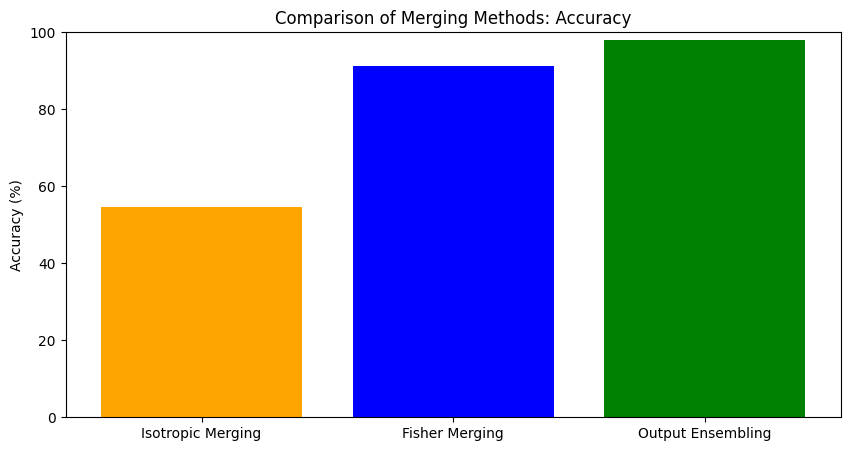

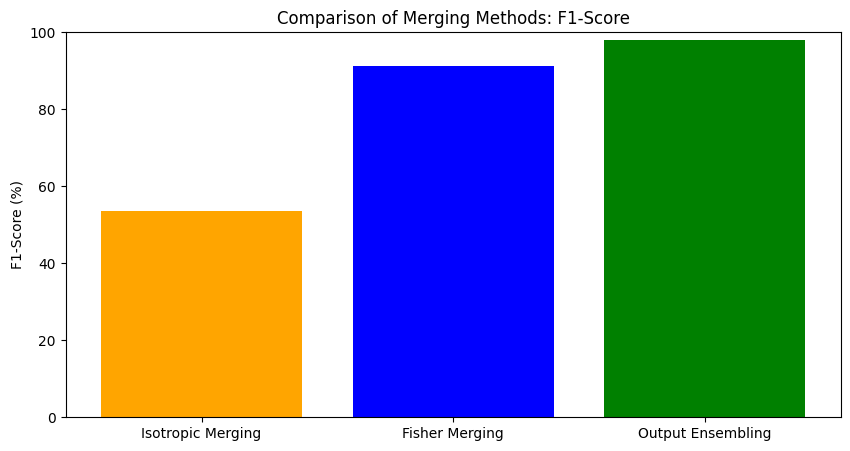

Plotting layer distributions...


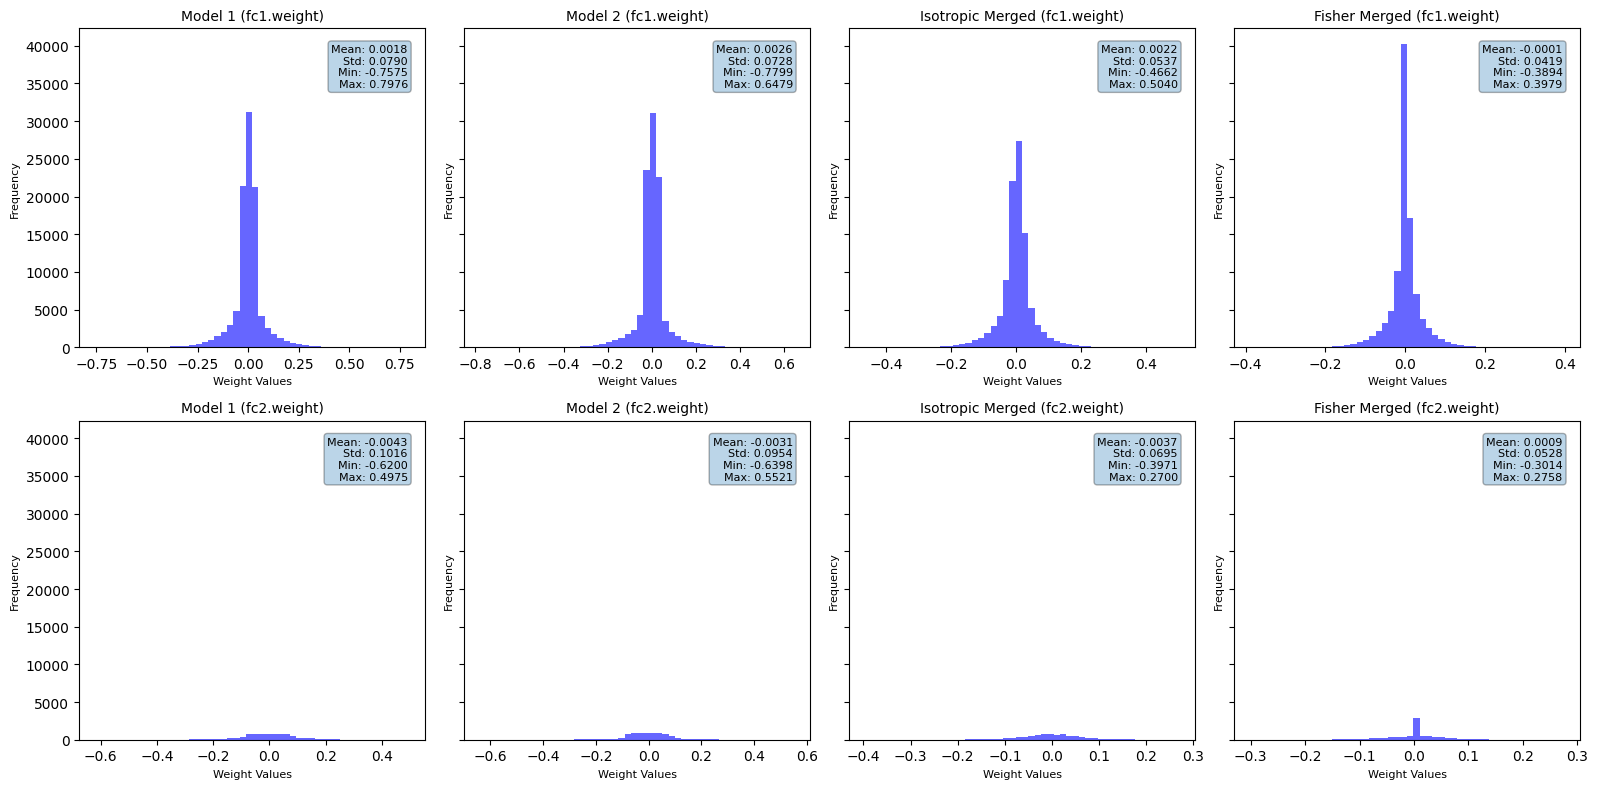

In [ ]:
# Simulate command-line arguments
sys.argv = [
    'Training, Merging, Validating two MLPs',
    '--command', 'train', 'merge', 'validate', 'visualize',
    '--dataset', 'mnist',
    '--model', 'mlp',
    '--epochs', '10'
]

main()


## Example2. Merging Two CNNs

Training Model 1...
Training on cpu...
Epoch 1/10, Loss: 0.15211941445877314
Epoch 2/10, Loss: 0.04530919888902005
Epoch 3/10, Loss: 0.03014753130740853
Epoch 4/10, Loss: 0.021952490532503418
Epoch 5/10, Loss: 0.01688300572863157
Epoch 6/10, Loss: 0.012678159910810675
Epoch 7/10, Loss: 0.011624378863583269
Epoch 8/10, Loss: 0.008239245599879277
Epoch 9/10, Loss: 0.0077613029725415485
Epoch 10/10, Loss: 0.007369100508101882
Training complete. Model moved to CPU.
Test Accuracy: 99.15%
Model saved at: saved_models/mnist_cnn_1.pth
Training Model 2...
Training on cpu...
Epoch 1/10, Loss: 0.15869001564391053
Epoch 2/10, Loss: 0.045904703710455574
Epoch 3/10, Loss: 0.03214947282493528
Epoch 4/10, Loss: 0.023733613343645276
Epoch 5/10, Loss: 0.01794824513818428
Epoch 6/10, Loss: 0.01354136622428992
Epoch 7/10, Loss: 0.01185406632753266
Epoch 8/10, Loss: 0.007188280456268994
Epoch 9/10, Loss: 0.0080868714032107
Epoch 10/10, Loss: 0.00677400165199145
Training complete. Model moved to CPU.
Test A

Computing Fisher Information: 100%|██████████| 938/938 [01:29<00:00, 10.50batch/s]
Merging Models: 8param [00:00, 1055.47param/s]


Model saved at: saved_models/mnist_cnn_merged.pth
Merging using isotropic averaging...
Model saved at: saved_models/mnist_cnn_isotropic_merged.pth
Isotropic merged model saved: mnist_cnn_isotropic_merged.pth
Merging using output ensembling...
Model saved at: saved_models/mnist_cnn_ensemble_merged.pth
Ensemble merged model saved: mnist_cnn_ensemble_merged.pth
Validating Model 1...


Validating Model: 100%|██████████| 157/157 [00:08<00:00, 19.56batch/s]


Validating Model 2...


Validating Model: 100%|██████████| 157/157 [00:08<00:00, 19.27batch/s]


Validating fisher Merged Model...


Validating Model: 100%|██████████| 157/157 [00:08<00:00, 17.79batch/s]


Validating isotropic Merged Model...


Validating Model: 100%|██████████| 157/157 [00:07<00:00, 20.86batch/s]


Validating ensemble Merged Model...


Validating Model: 100%|██████████| 157/157 [00:13<00:00, 11.55batch/s]


Validation results:
model1: {'loss': 0.03539406002594705, 'accuracy': 0.9915, 'f1_score': 0.9914949916487532, 'precision': 0.9915206009972429, 'recall': 0.9915}
model2: {'loss': 0.039365780806241646, 'accuracy': 0.9891, 'f1_score': 0.9891040217162248, 'precision': 0.9891519955081054, 'recall': 0.9891}
fisher: {'loss': 1.4943578228069718, 'accuracy': 0.9123, 'f1_score': 0.9018959636847547, 'precision': 0.9255527853244357, 'recall': 0.9123}
isotropic: {'loss': 1.5740670436506818, 'accuracy': 0.8478, 'f1_score': 0.8464137182361006, 'precision': 0.8766050493008696, 'recall': 0.8478}
ensemble: {'loss': 0.026893504289703725, 'accuracy': 0.9926, 'f1_score': 0.9926004622199577, 'precision': 0.9926131770549522, 'recall': 0.9926}
Generating comparison chart...


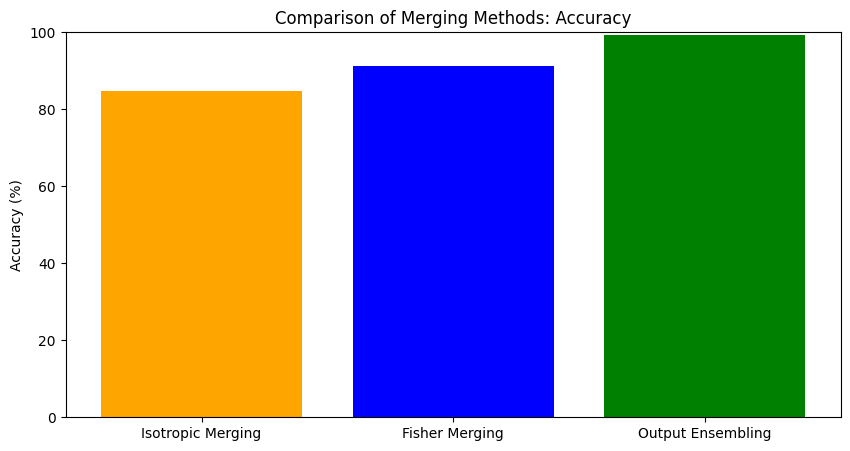

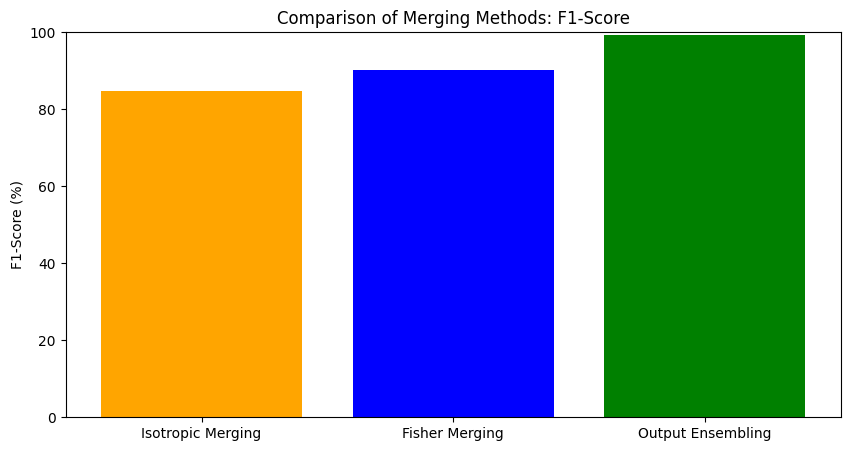

Plotting layer distributions...


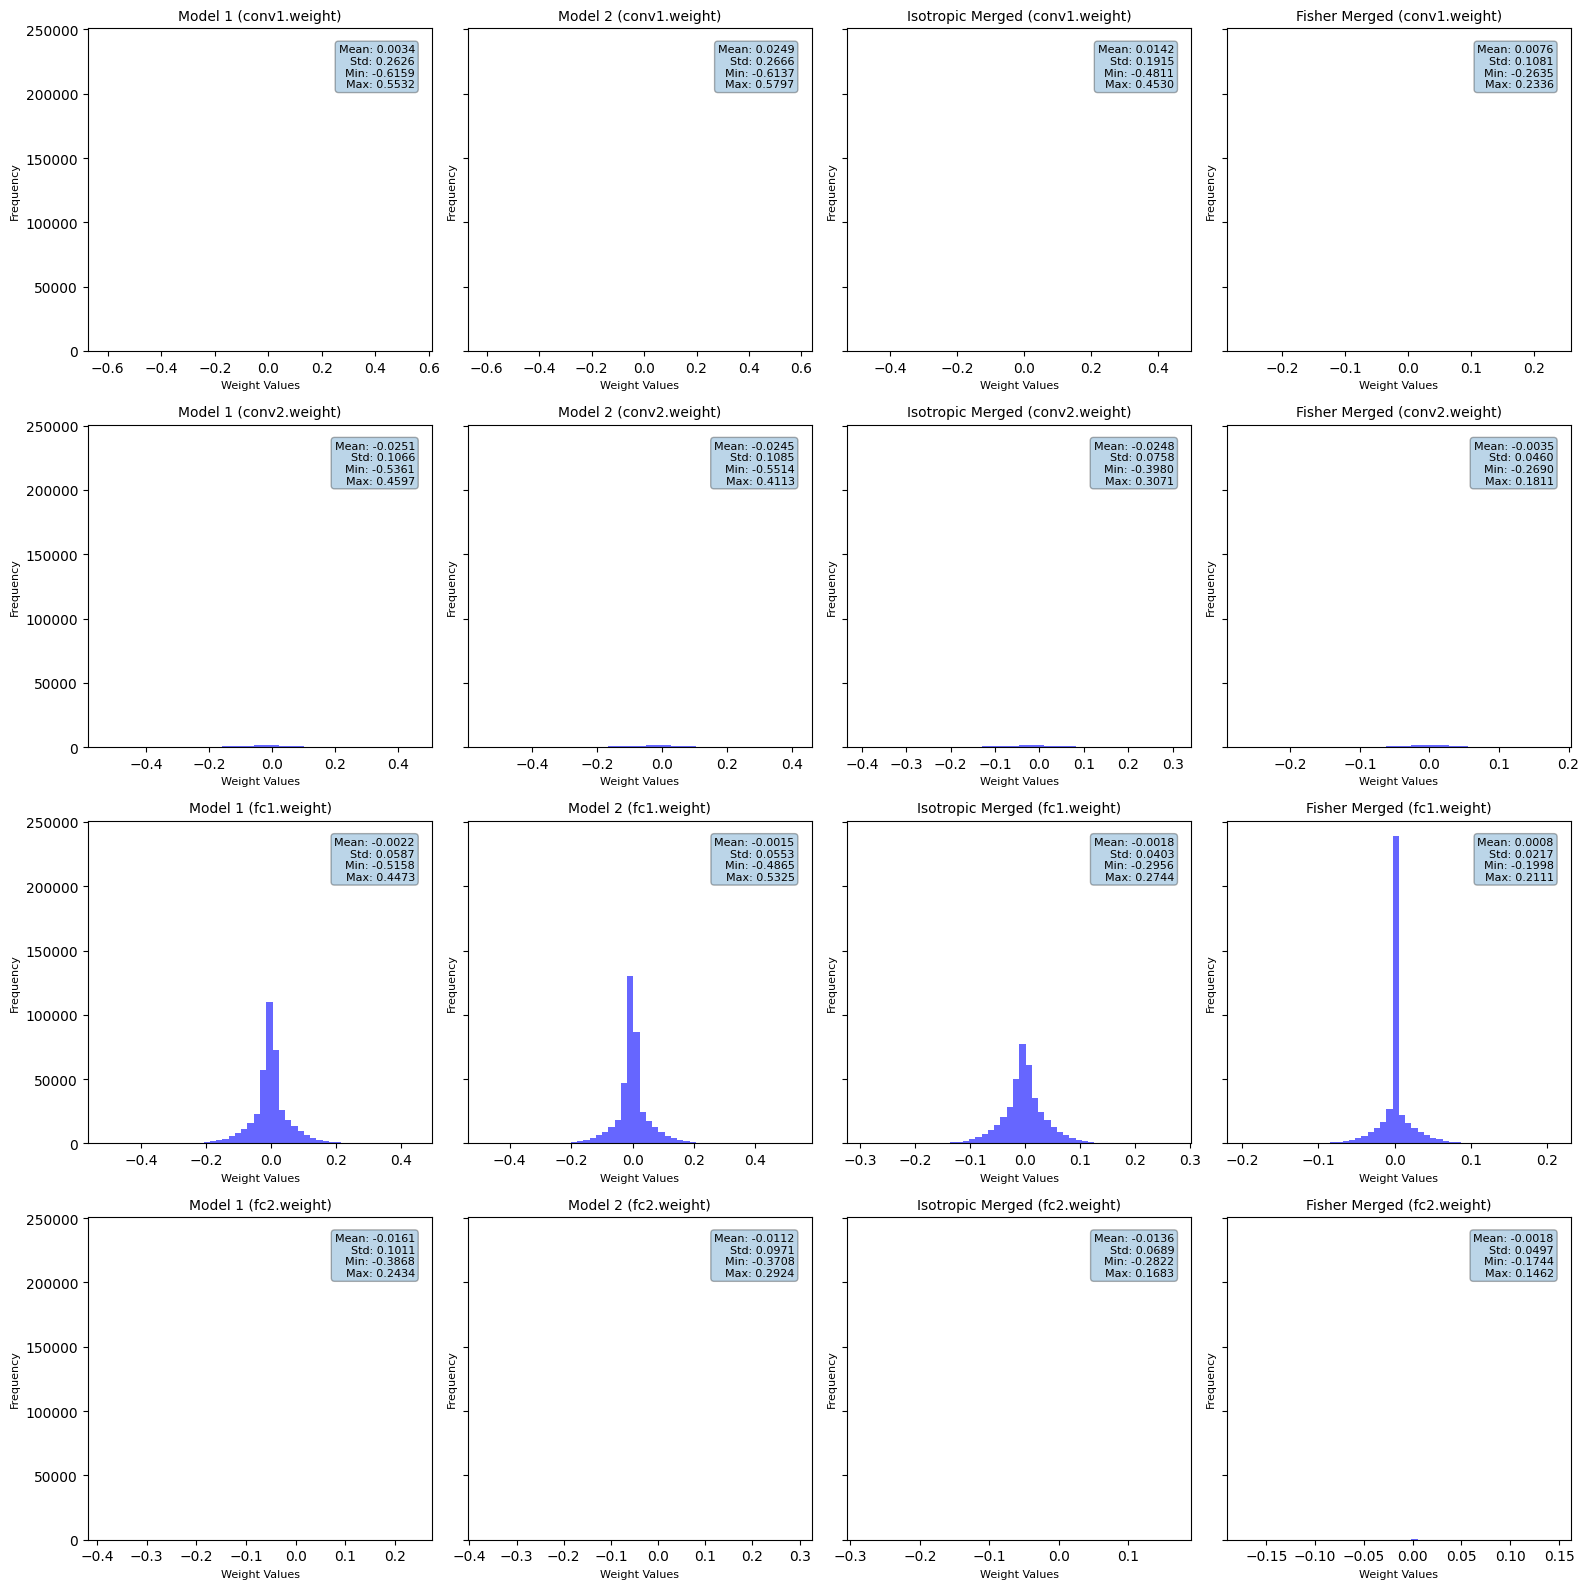

In [ ]:
# Simulate command-line arguments
sys.argv = [
    'Training, Merging, Validating two CNNs',
    '--command', 'train', 'merge', 'validate', 'visualize',
    '--dataset', 'mnist',
    '--model', 'cnn',
    '--epochs', '10'
]

main()


## Example3. Divergent Model Merging

Initializing divergent datasets: MNIST and Fashion-MNIST
Training Model 1 on mnist...
Hyperparameters are {'lr': 0.01, 'weight_decay': 1e-05}...
Training on cpu...
Epoch 1/10, Loss: 0.38321150736466275
Epoch 2/10, Loss: 0.24759715044303043
Epoch 3/10, Loss: 0.23063402117660908
Epoch 4/10, Loss: 0.2126994721580551
Epoch 5/10, Loss: 0.20367767587740984
Epoch 6/10, Loss: 0.21059568564512773
Epoch 7/10, Loss: 0.20034399057136798
Epoch 8/10, Loss: 0.19300587394578592
Epoch 9/10, Loss: 0.1864677582195263
Epoch 10/10, Loss: 0.18320309111167357
Training complete. Model moved to CPU.
Test Accuracy: 94.52%
Model saved at: saved_models/mnist_mlp_mnist.pth
Model saved at: mnist_mlp_mnist.pth
Training Model 2 on fashion-mnist...
Hyperparameters are {'lr': 0.001, 'weight_decay': 0.0001}...
Training on cpu...
Epoch 1/10, Loss: 0.5151533625686346
Epoch 2/10, Loss: 0.3829419132806599
Epoch 3/10, Loss: 0.34525238436613004
Epoch 4/10, Loss: 0.3221306103839676
Epoch 5/10, Loss: 0.3059000663125693
Epoch 6/

Computing Fisher Information: 100%|██████████| 938/938 [00:29<00:00, 32.07batch/s]


Computing Fisher Information for Model 2 on fashion-mnist...


Computing Fisher Information: 100%|██████████| 938/938 [00:20<00:00, 46.23batch/s]


Merging models trained on mnist and fashion-mnist using Fisher-weighted averaging...


Merging Models: 6param [00:00, 1691.71param/s]


Model saved at: saved_models/mnist_fashion-mnist_mlp_fisher_merged.pth
Fisher-merged model saved at: mnist_fashion-mnist_mlp_fisher_merged.pth
Model saved at: saved_models/mnist_fashion-mnist_mlp_fisher_merged.pth
Fisher merged model saved: mnist_fashion-mnist_mlp_fisher_merged.pth
Merging using isotropic averaging for mnist and fashion-mnist...
Model saved at: saved_models/mnist_fashion-mnist_mlp_isotropic_merged.pth
Isotropic merged model saved: mnist_fashion-mnist_mlp_isotropic_merged.pth
Merging using output ensembling for mnist and fashion-mnist...
Model saved at: saved_models/mnist_fashion-mnist_mlp_ensemble_merged.pth
Ensemble merged model saved: mnist_fashion-mnist_mlp_ensemble_merged.pth
Validating Model 1...
Validating on mnist dataset...


Validating Model: 100%|██████████| 157/157 [00:05<00:00, 29.14batch/s]


Validating on fashion-mnist dataset...


Validating Model: 100%|██████████| 157/157 [00:04<00:00, 36.53batch/s]


Validating Model 2...
Validating on mnist dataset...


Validating Model: 100%|██████████| 157/157 [00:02<00:00, 53.20batch/s]


Validating on fashion-mnist dataset...


Validating Model: 100%|██████████| 157/157 [00:03<00:00, 49.41batch/s]


Validating fisher Merged Model...
Validating on mnist dataset...


Validating Model: 100%|██████████| 157/157 [00:03<00:00, 41.85batch/s]


Validating on fashion-mnist dataset...


Validating Model: 100%|██████████| 157/157 [00:02<00:00, 53.64batch/s]


Validating isotropic Merged Model...
Validating on mnist dataset...


Validating Model: 100%|██████████| 157/157 [00:02<00:00, 53.94batch/s]


Validating on fashion-mnist dataset...


Validating Model: 100%|██████████| 157/157 [00:02<00:00, 54.12batch/s]


Validating ensemble Merged Model...
Validating on mnist dataset...


Validating Model: 100%|██████████| 157/157 [00:05<00:00, 28.80batch/s]


Validating on fashion-mnist dataset...


Validating Model: 100%|██████████| 157/157 [00:04<00:00, 35.47batch/s]


Validation results:
model1: {'mnist': {'loss': 0.20858177554735818, 'accuracy': 0.9452, 'f1_score': 0.9453014102734991, 'precision': 0.9467077188336097, 'recall': 0.9452}, 'fashion-mnist': {'loss': 8.541889828481493, 'accuracy': 0.0599, 'f1_score': 0.04534097902650253, 'precision': 0.1155634022264434, 'recall': 0.0599}}
model2: {'mnist': {'loss': 6.559133629890004, 'accuracy': 0.0768, 'f1_score': 0.07923183296281792, 'precision': 0.11465788821278722, 'recall': 0.0768}, 'fashion-mnist': {'loss': 0.34083896733013685, 'accuracy': 0.881, 'f1_score': 0.8808820495723907, 'precision': 0.8814158430853056, 'recall': 0.881}}
fisher: {'mnist': {'loss': 1.6025436273805655, 'accuracy': 0.5913, 'f1_score': 0.5820817043014834, 'precision': 0.6257852708587929, 'recall': 0.5913}, 'fashion-mnist': {'loss': 1.6919426986366322, 'accuracy': 0.551, 'f1_score': 0.5591850393705614, 'precision': 0.6229268802233406, 'recall': 0.551}}
isotropic: {'mnist': {'loss': 1.352488421330786, 'accuracy': 0.6055, 'f1_score

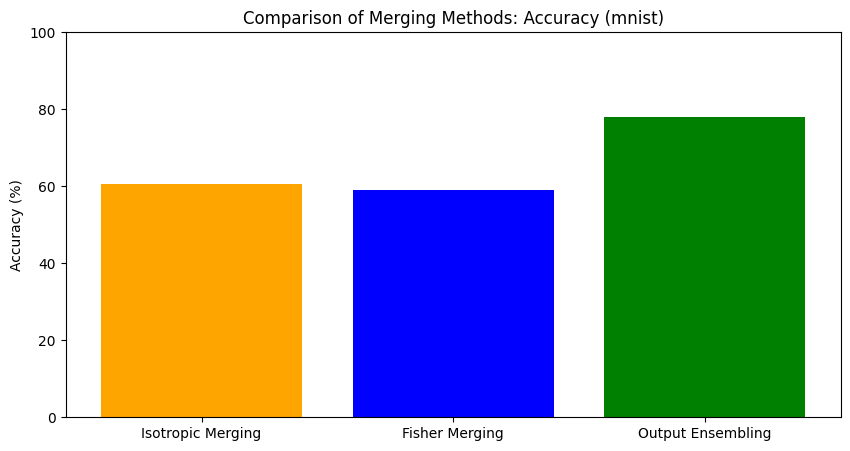

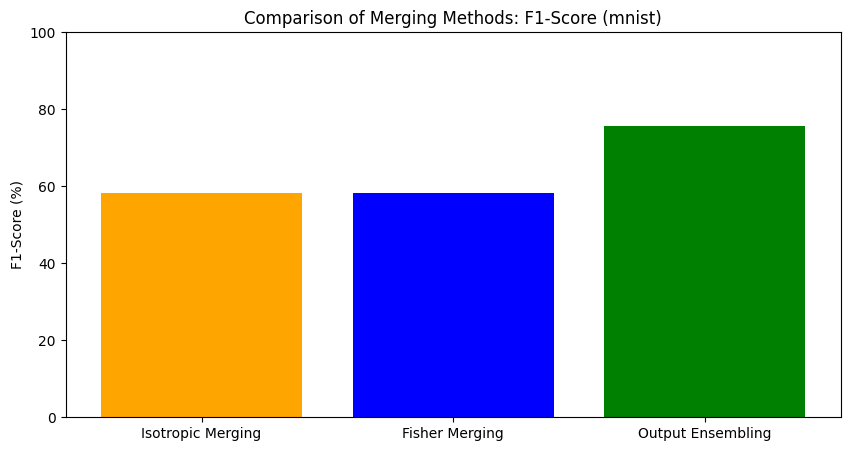

Generating comparison charts for fashion-mnist...


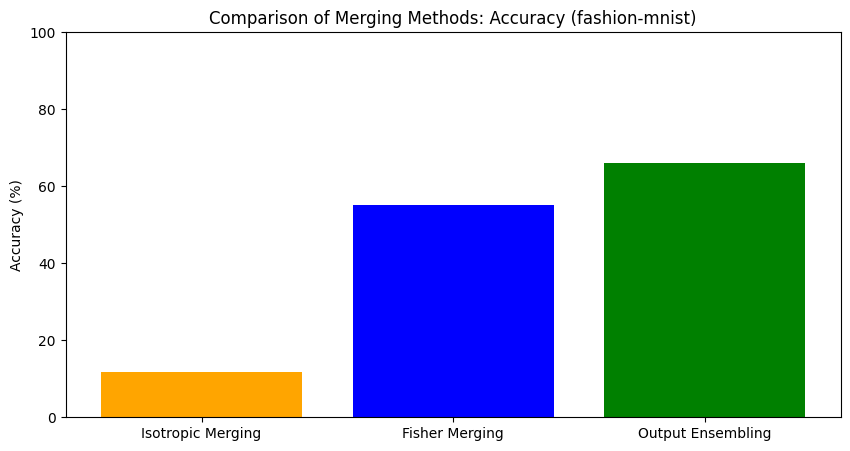

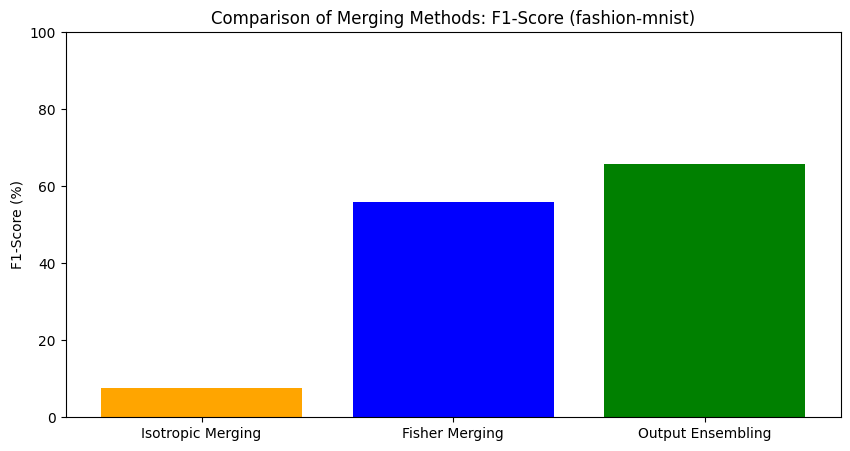

Plotting layer distributions...


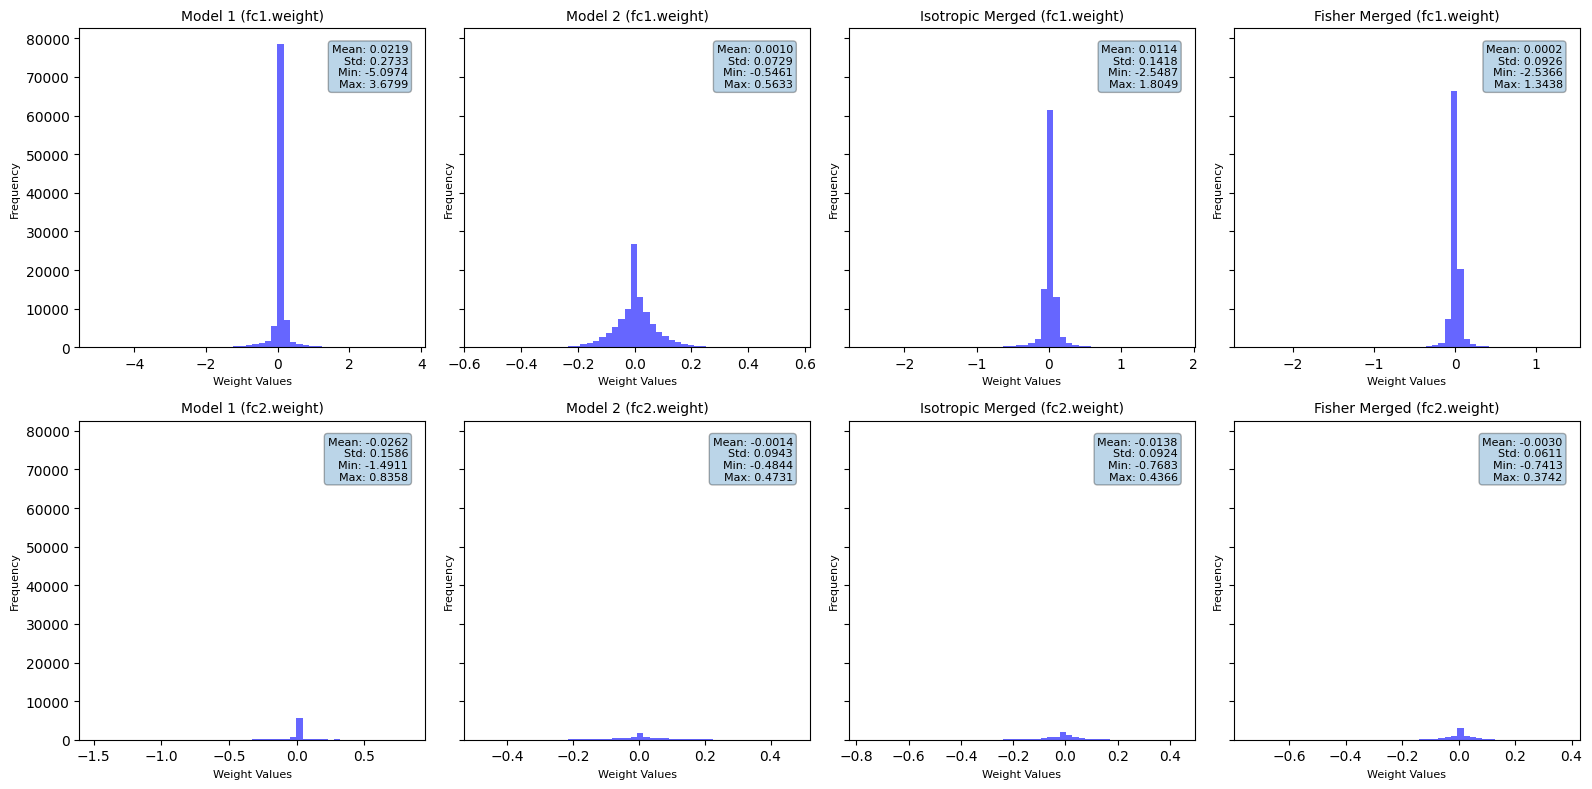

In [ ]:
sys.argv = [
    'Merging across models trained on different datasets and with different hyperparameters',
    '--command', 'train', 'merge', 'validate', 'visualize',
    '--dataset', 'mnist', 'fashion-mnist',
    '--model', 'mlp',
    '--epochs', '10'
]

# Call the main function
main()


## Example4. Robustness to Noise

Training with noise enabled for specified models...
Training Model 1 without noise...
Training on cpu...
Epoch 1/10, Loss: 0.39432798229110266
Epoch 2/10, Loss: 0.19044250824542314
Epoch 3/10, Loss: 0.1425881963004785
Epoch 4/10, Loss: 0.11327709429768293
Epoch 5/10, Loss: 0.09754481148183235
Epoch 6/10, Loss: 0.08233883722311953
Epoch 7/10, Loss: 0.07809194956205166
Epoch 8/10, Loss: 0.06927076493924074
Epoch 9/10, Loss: 0.061756667472781544
Epoch 10/10, Loss: 0.05490977462582928
Training complete. Model moved to CPU.
Test Accuracy: 97.69%
Model saved at: saved_models/mnist_mlp_1.pth
Model saved at: mnist_mlp_1.pth
Training Model 2 with noise...
Training on cpu...
Epoch 1/10, Loss: 0.8297813563967056
Epoch 2/10, Loss: 0.6458806440011778
Epoch 3/10, Loss: 0.5924329184837687
Epoch 4/10, Loss: 0.5555894285885256
Epoch 5/10, Loss: 0.5263438400492739
Epoch 6/10, Loss: 0.5012967404780357
Epoch 7/10, Loss: 0.4781300204712699
Epoch 8/10, Loss: 0.4558813424665791
Epoch 9/10, Loss: 0.4341244444

Computing Fisher Information: 100%|██████████| 938/938 [00:19<00:00, 47.01batch/s]


Computing Fisher Information for Model 2...


Computing Fisher Information: 100%|██████████| 938/938 [00:20<00:00, 44.92batch/s]


Merging models using Fisher-weighted averaging...


Merging Models: 6param [00:00, 1480.08param/s]


Model saved at: saved_models/['mnist']_mlp_fisher_merged.pth
Fisher-merged model saved at: ['mnist']_mlp_fisher_merged.pth
Model saved at: saved_models/['mnist']_mlp_fisher_merged.pth
Fisher merged model saved: ['mnist']_mlp_fisher_merged.pth
Merging using isotropic averaging...
Model saved at: saved_models/['mnist']_mlp_isotropic_merged.pth
Isotropic merged model saved: ['mnist']_mlp_isotropic_merged.pth
Merging using output ensembling...
Model saved at: saved_models/['mnist']_mlp_ensemble_merged.pth
Ensemble merged model saved: ['mnist']_mlp_ensemble_merged.pth
Validating Model 1...


Validating Model: 100%|██████████| 157/157 [00:02<00:00, 54.56batch/s]


Validating Model 2...


Validating Model: 100%|██████████| 157/157 [00:02<00:00, 55.05batch/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validating fisher Merged Model...


Validating Model: 100%|██████████| 157/157 [00:03<00:00, 40.17batch/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validating isotropic Merged Model...


Validating Model: 100%|██████████| 157/157 [00:03<00:00, 52.08batch/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Validating ensemble Merged Model...


Validating Model: 100%|██████████| 157/157 [00:03<00:00, 51.62batch/s]


Validation results:
model1: {'loss': 0.07858978411143647, 'accuracy': 0.9769, 'f1_score': 0.9768996131558139, 'precision': 0.9770810019424194, 'recall': 0.9769}
model2: {'loss': 18.26868189671996, 'accuracy': 0.1009, 'f1_score': 0.02403273674676286, 'precision': 0.2507833297091669, 'recall': 0.1009}
fisher: {'loss': 2.7486454620482816, 'accuracy': 0.1054, 'f1_score': 0.045960148905082474, 'precision': 0.22909868737759212, 'recall': 0.1054}
isotropic: {'loss': 3.0952887489537524, 'accuracy': 0.3013, 'f1_score': 0.20551594696269684, 'precision': 0.37745975185551744, 'recall': 0.3013}
ensemble: {'loss': 2.92652259074199, 'accuracy': 0.5463, 'f1_score': 0.535975937873658, 'precision': 0.801580917591418, 'recall': 0.5463}
Generating comparison chart...
Generating comparison charts for a single dataset...


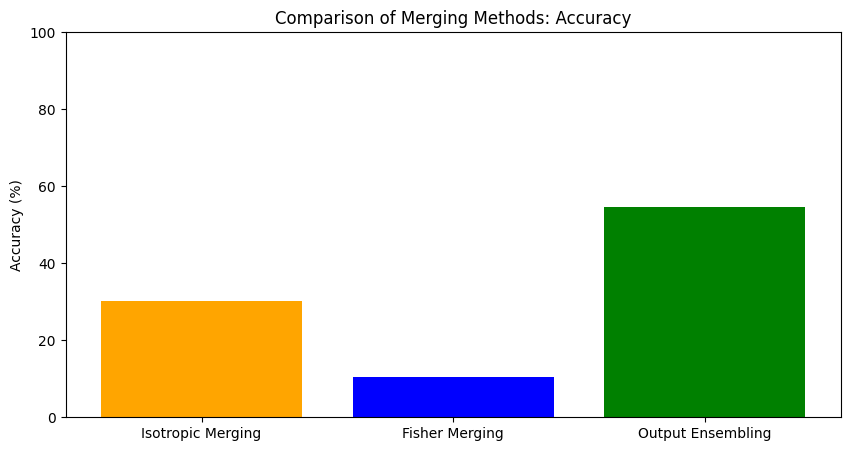

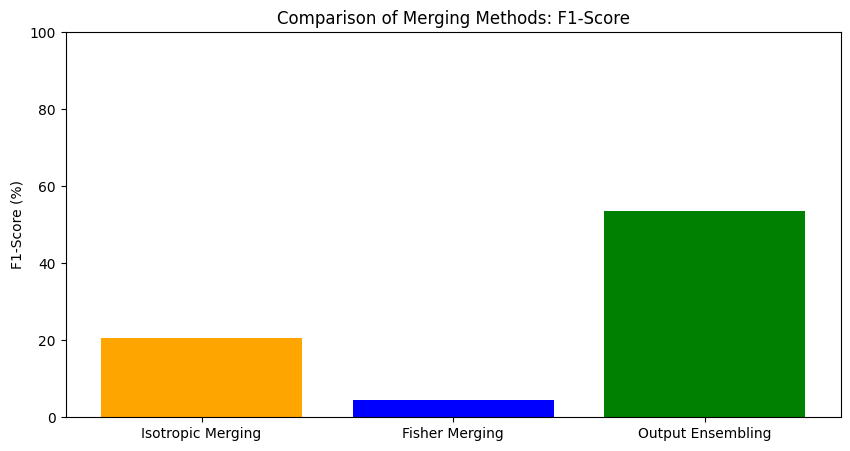

Plotting layer distributions...


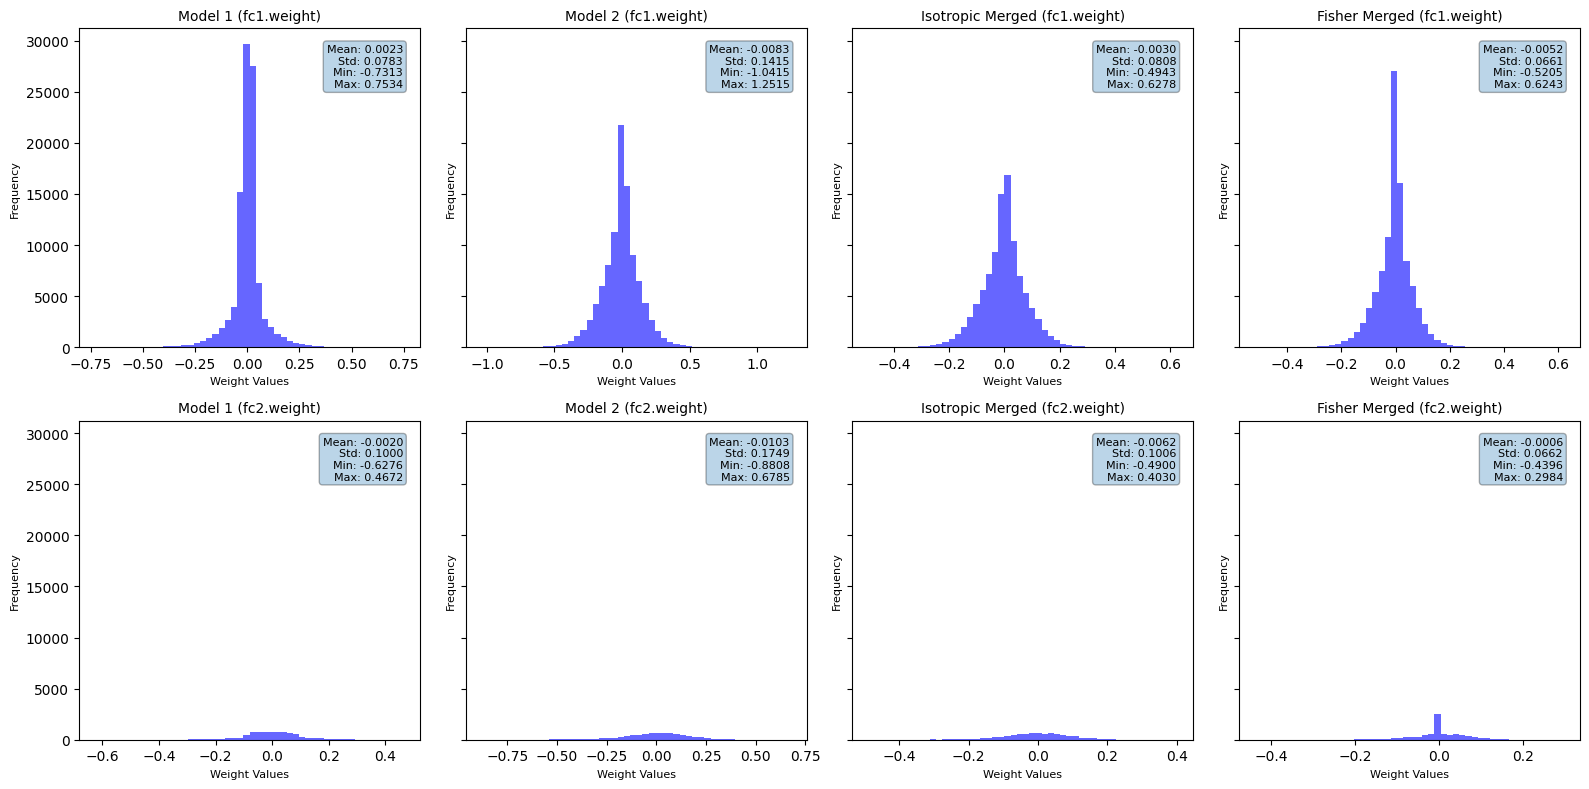

In [ ]:
sys.argv = [
    'Merging noisy models. How well does merging handles noises?',
    '--command', 'train', 'merge', 'validate', 'visualize',
    '--dataset', 'mnist',
    '--model', 'mlp',
    '--epochs', '10',
    '--noisy_models', 'model2'
]

# Call the main function
main()


## Example5. Ablation Studies

### Performing Fisher Scaling

Training Model 1...
Training on cpu...
Epoch 1/10, Loss: 0.4074789103525661
Epoch 2/10, Loss: 0.1947562138536083
Epoch 3/10, Loss: 0.14369062409956634
Epoch 4/10, Loss: 0.11684978732080666
Epoch 5/10, Loss: 0.09890050605298883
Epoch 6/10, Loss: 0.08758572271979376
Epoch 7/10, Loss: 0.07761011251768689
Epoch 8/10, Loss: 0.07044979963868138
Epoch 9/10, Loss: 0.06453775909311299
Epoch 10/10, Loss: 0.059669003474276894
Training complete. Model moved to CPU.
Test Accuracy: 97.31%
Model saved at: saved_models/mnist_mlp_1.pth
Model saved at: mnist_mlp_1.pth
Training Model 2...
Training on cpu...
Epoch 1/10, Loss: 0.37645274188631633
Epoch 2/10, Loss: 0.17516648146643568
Epoch 3/10, Loss: 0.13055716816987248
Epoch 4/10, Loss: 0.10532520462407359
Epoch 5/10, Loss: 0.0901431544546856
Epoch 6/10, Loss: 0.0798781475574493
Epoch 7/10, Loss: 0.07059364685930733
Epoch 8/10, Loss: 0.06259962416259941
Epoch 9/10, Loss: 0.05809637460566467
Epoch 10/10, Loss: 0.051452580467127126
Training complete. Model

Computing Fisher Information: 100%|██████████| 938/938 [00:20<00:00, 46.67batch/s]


Computing Fisher Information for Model 2...


Computing Fisher Information: 100%|██████████| 938/938 [00:18<00:00, 49.43batch/s]


Running Fisher Scaling Experiment...
Testing Fisher Scaling Factor β = 0.001...


Merging Models: 6param [00:00, 1706.62param/s]
Validating Model: 100%|██████████| 157/157 [00:02<00:00, 56.58batch/s]


Accuracy for β = 0.001: 0.8436
Testing Fisher Scaling Factor β = 0.01...


Merging Models: 6param [00:00, 1817.81param/s]
Validating Model: 100%|██████████| 157/157 [00:03<00:00, 51.12batch/s]


Accuracy for β = 0.01: 0.8672
Testing Fisher Scaling Factor β = 0.1...


Merging Models: 6param [00:00, 2023.46param/s]
Validating Model: 100%|██████████| 157/157 [00:04<00:00, 32.77batch/s]


Accuracy for β = 0.1: 0.8705
Testing Fisher Scaling Factor β = 0.5...


Merging Models: 6param [00:00, 1542.31param/s]
Validating Model: 100%|██████████| 157/157 [00:02<00:00, 52.71batch/s]


Accuracy for β = 0.5: 0.8688
Testing Fisher Scaling Factor β = 1.0...


Merging Models: 6param [00:00, 1191.00param/s]
Validating Model: 100%|██████████| 157/157 [00:02<00:00, 55.93batch/s]


Accuracy for β = 1.0: 0.8677
Testing Fisher Scaling Factor β = 2.0...


Merging Models: 6param [00:00, 1474.79param/s]
Validating Model: 100%|██████████| 157/157 [00:02<00:00, 57.40batch/s]


Accuracy for β = 2.0: 0.8673
Testing Fisher Scaling Factor β = 5.0...


Merging Models: 6param [00:00, 2173.21param/s]
Validating Model: 100%|██████████| 157/157 [00:03<00:00, 42.95batch/s]


Accuracy for β = 5.0: 0.8667
Testing Fisher Scaling Factor β = 10.0...


Merging Models: 6param [00:00, 1588.45param/s]
Validating Model: 100%|██████████| 157/157 [00:02<00:00, 54.69batch/s]


Accuracy for β = 10.0: 0.8661

Best Fisher Scaling Factor: β = 0.1 with Accuracy: 0.8705


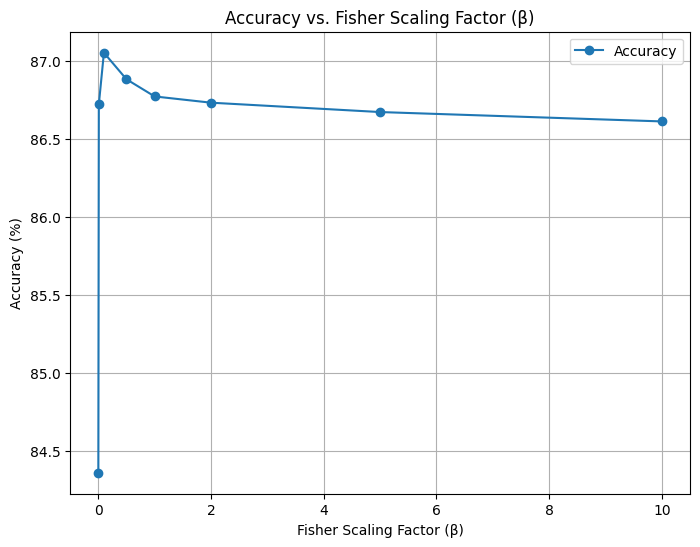

Merging models using Fisher-weighted averaging...


Merging Models: 6param [00:00, 2145.24param/s]


Model saved at: saved_models/mnist_mlp_fisher_merged.pth
Fisher-merged model saved at: mnist_mlp_fisher_merged.pth
Model saved at: saved_models/mnist_mlp_fisher_merged.pth
Fisher merged model saved: ['mnist']_mlp_fisher_merged.pth
Merging using isotropic averaging...
Model saved at: saved_models/mnist_mlp_isotropic_merged.pth
Isotropic merged model saved: ['mnist']_mlp_isotropic_merged.pth
Merging using output ensembling...
Model saved at: saved_models/mnist_mlp_ensemble_merged.pth
Ensemble merged model saved: ['mnist']_mlp_ensemble_merged.pth
Validating Model 1...


Validating Model: 100%|██████████| 157/157 [00:02<00:00, 56.86batch/s]


Validating Model 2...


Validating Model: 100%|██████████| 157/157 [00:02<00:00, 56.23batch/s]


Validating fisher Merged Model...


Validating Model: 100%|██████████| 157/157 [00:03<00:00, 47.99batch/s]


Validating isotropic Merged Model...


Validating Model: 100%|██████████| 157/157 [00:03<00:00, 45.99batch/s]


Validating ensemble Merged Model...


Validating Model: 100%|██████████| 157/157 [00:02<00:00, 53.29batch/s]


Validation results:
model1: {'loss': 0.09324535464139055, 'accuracy': 0.9731, 'f1_score': 0.9730870048028499, 'precision': 0.9733890371405678, 'recall': 0.9731}
model2: {'loss': 0.09668152353238421, 'accuracy': 0.9703, 'f1_score': 0.9703756213096071, 'precision': 0.9708410877486716, 'recall': 0.9703}
fisher: {'loss': 1.2326704628148657, 'accuracy': 0.8705, 'f1_score': 0.8706455669806715, 'precision': 0.8861471533105724, 'recall': 0.8705}
isotropic: {'loss': 1.3312808184107399, 'accuracy': 0.496, 'f1_score': 0.4769555110836101, 'precision': 0.7248143634459815, 'recall': 0.496}
ensemble: {'loss': 0.07222361392451852, 'accuracy': 0.9773, 'f1_score': 0.9773296423147633, 'precision': 0.9775517825629205, 'recall': 0.9773}
Generating comparison chart...
Generating comparison charts for a single dataset...


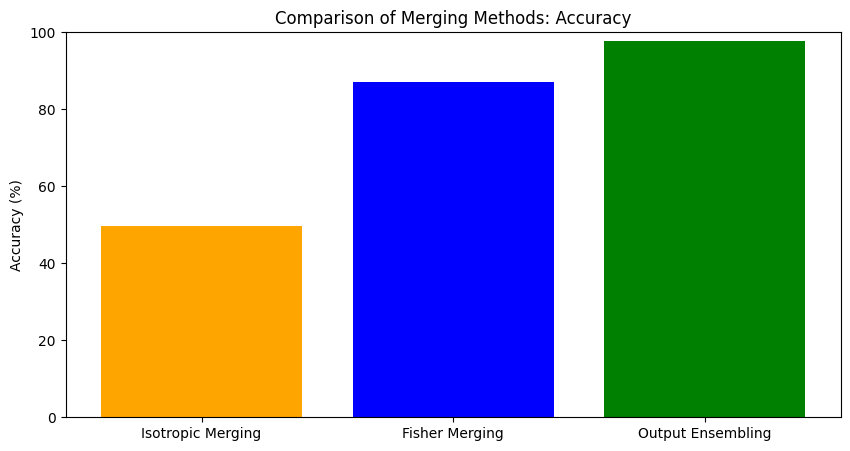

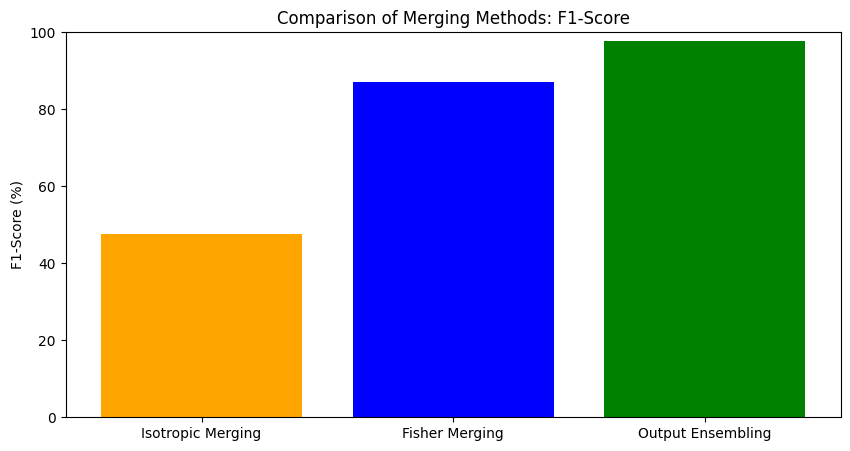

Plotting layer distributions...


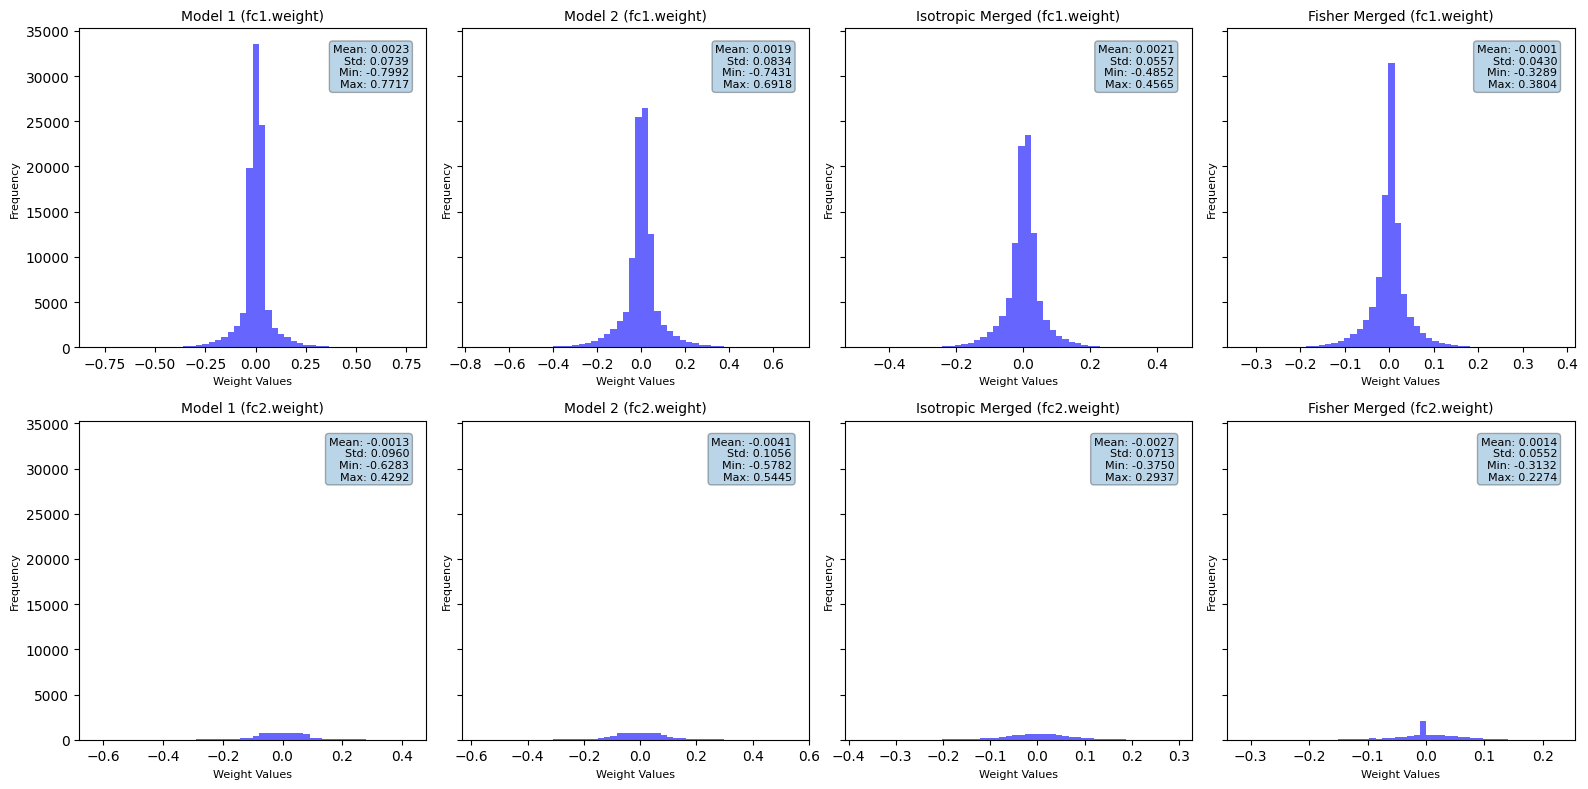

In [22]:
sys.argv = [
    'The impact of Fisher scaling on model performance.',
    '--command', 'train', 'merge', 'validate', 'visualize',
    '--dataset', 'mnist',
    '--model', 'mlp',
    '--epochs', '10',
    '--ablation', 'fisher_scaling',
    '--scaling_factor', '0.001',  '0.01',  '0.1' , '0.5', '1.0', '2.0', '5.0', '10.0'
]
main()

### Performing Fisher Scaling (Imposing Uniform Weighting)

Training Model 1...
Training on cpu...
Epoch 1/10, Loss: 0.38934874979417716
Epoch 2/10, Loss: 0.18219775091737572
Epoch 3/10, Loss: 0.13316806405881987
Epoch 4/10, Loss: 0.10656781633174035
Epoch 5/10, Loss: 0.08831974085041089
Epoch 6/10, Loss: 0.07835537471127377
Epoch 7/10, Loss: 0.0722266813081854
Epoch 8/10, Loss: 0.06340073318139258
Epoch 9/10, Loss: 0.059660474637097345
Epoch 10/10, Loss: 0.051667386566776274
Training complete. Model moved to CPU.
Test Accuracy: 97.47%
Model saved at: saved_models/mnist_mlp_1.pth
Model saved at: mnist_mlp_1.pth
Training Model 2...
Training on cpu...
Epoch 1/10, Loss: 0.39908819023702446
Epoch 2/10, Loss: 0.1928417342407172
Epoch 3/10, Loss: 0.1399144185826119
Epoch 4/10, Loss: 0.1136808842420578
Epoch 5/10, Loss: 0.0954251583225763
Epoch 6/10, Loss: 0.08322839636895765
Epoch 7/10, Loss: 0.07241892412171833
Epoch 8/10, Loss: 0.06692996651873981
Epoch 9/10, Loss: 0.05883323655067595
Epoch 10/10, Loss: 0.056690444828503564
Training complete. Model

Computing Fisher Information: 100%|██████████| 938/938 [00:19<00:00, 48.75batch/s]


Computing Fisher Information for Model 2...


Computing Fisher Information: 100%|██████████| 938/938 [00:20<00:00, 45.83batch/s]


Running Fisher Scaling Experiment...
Testing Fisher Scaling Factor β = 0.001...


Merging Models: 6param [00:00, 4685.50param/s]
Validating Model: 100%|██████████| 157/157 [00:02<00:00, 56.64batch/s]


Accuracy for β = 0.001: 0.6852
Testing Fisher Scaling Factor β = 0.01...


Merging Models: 6param [00:00, 4983.33param/s]
Validating Model: 100%|██████████| 157/157 [00:02<00:00, 55.61batch/s]


Accuracy for β = 0.01: 0.6852
Testing Fisher Scaling Factor β = 0.1...


Merging Models: 6param [00:00, 4843.31param/s]
Validating Model: 100%|██████████| 157/157 [00:03<00:00, 46.06batch/s]


Accuracy for β = 0.1: 0.6852
Testing Fisher Scaling Factor β = 0.5...


Merging Models: 6param [00:00, 1197.75param/s]
Validating Model: 100%|██████████| 157/157 [00:03<00:00, 47.75batch/s]


Accuracy for β = 0.5: 0.6852
Testing Fisher Scaling Factor β = 1.0...


Merging Models: 6param [00:00, 2384.93param/s]
Validating Model: 100%|██████████| 157/157 [00:02<00:00, 55.85batch/s]


Accuracy for β = 1.0: 0.6852
Testing Fisher Scaling Factor β = 2.0...


Merging Models: 6param [00:00, 3430.46param/s]
Validating Model: 100%|██████████| 157/157 [00:03<00:00, 40.00batch/s]


Accuracy for β = 2.0: 0.6852
Testing Fisher Scaling Factor β = 5.0...


Merging Models: 6param [00:00, 2781.06param/s]
Validating Model: 100%|██████████| 157/157 [00:03<00:00, 44.58batch/s]


Accuracy for β = 5.0: 0.6852
Testing Fisher Scaling Factor β = 10.0...


Merging Models: 6param [00:00, 1510.74param/s]
Validating Model: 100%|██████████| 157/157 [00:03<00:00, 48.44batch/s]


Accuracy for β = 10.0: 0.6852

Best Fisher Scaling Factor: β = 0.001 with Accuracy: 0.6852


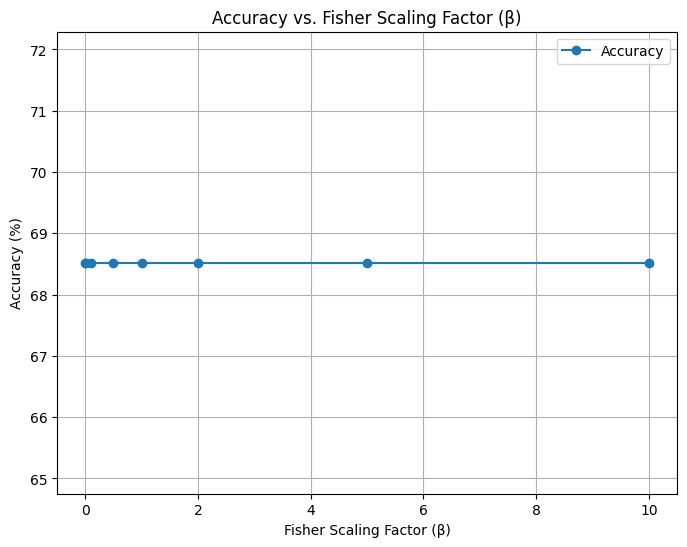

Merging models using Fisher-weighted averaging...


Merging Models: 6param [00:00, 2259.25param/s]


Model saved at: saved_models/mnist_mlp_fisher_merged.pth
Fisher-merged model saved at: mnist_mlp_fisher_merged.pth
Model saved at: saved_models/mnist_mlp_fisher_merged.pth
Fisher merged model saved: ['mnist']_mlp_fisher_merged.pth
Merging using isotropic averaging...
Model saved at: saved_models/mnist_mlp_isotropic_merged.pth
Isotropic merged model saved: ['mnist']_mlp_isotropic_merged.pth
Merging using output ensembling...
Model saved at: saved_models/mnist_mlp_ensemble_merged.pth
Ensemble merged model saved: ['mnist']_mlp_ensemble_merged.pth
Validating Model 1...


Validating Model: 100%|██████████| 157/157 [00:02<00:00, 53.36batch/s]


Validating Model 2...


Validating Model: 100%|██████████| 157/157 [00:04<00:00, 36.66batch/s]


Validating fisher Merged Model...


Validating Model: 100%|██████████| 157/157 [00:07<00:00, 20.80batch/s]


Validating isotropic Merged Model...


Validating Model: 100%|██████████| 157/157 [00:03<00:00, 40.12batch/s]


Validating ensemble Merged Model...


Validating Model: 100%|██████████| 157/157 [00:02<00:00, 53.84batch/s]


Validation results:
model1: {'loss': 0.07886861508288036, 'accuracy': 0.9747, 'f1_score': 0.9746857651261968, 'precision': 0.9748383032365994, 'recall': 0.9747}
model2: {'loss': 0.08885945989510266, 'accuracy': 0.9738, 'f1_score': 0.9738138472516065, 'precision': 0.9740794909550413, 'recall': 0.9738}
fisher: {'loss': 1.0430140290290686, 'accuracy': 0.6852, 'f1_score': 0.6801590468941213, 'precision': 0.7784054776259541, 'recall': 0.6852}
isotropic: {'loss': 1.0430140290290686, 'accuracy': 0.6852, 'f1_score': 0.6801590468941213, 'precision': 0.7784054776259541, 'recall': 0.6852}
ensemble: {'loss': 0.061552772565510686, 'accuracy': 0.9806, 'f1_score': 0.9806000061265008, 'precision': 0.9806320380725417, 'recall': 0.9806}
Generating comparison chart...
Generating comparison charts for a single dataset...


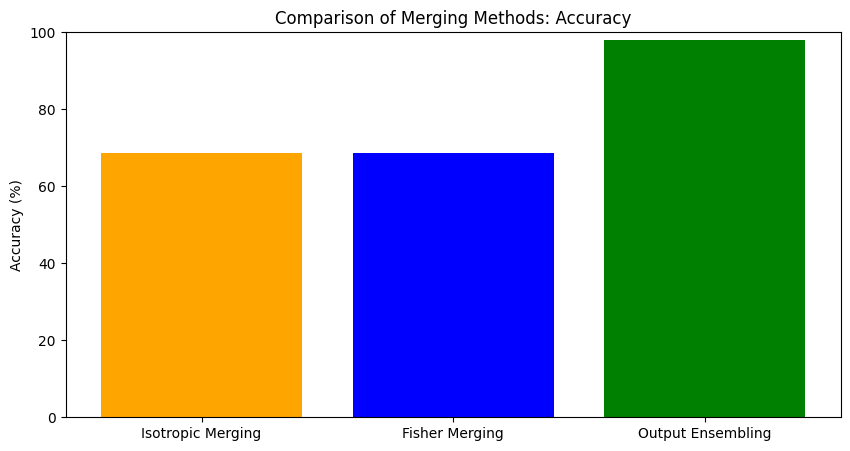

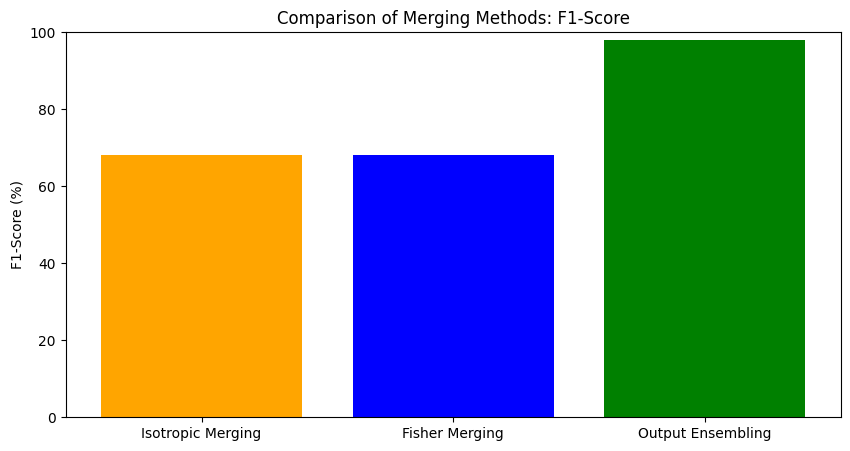

Plotting layer distributions...


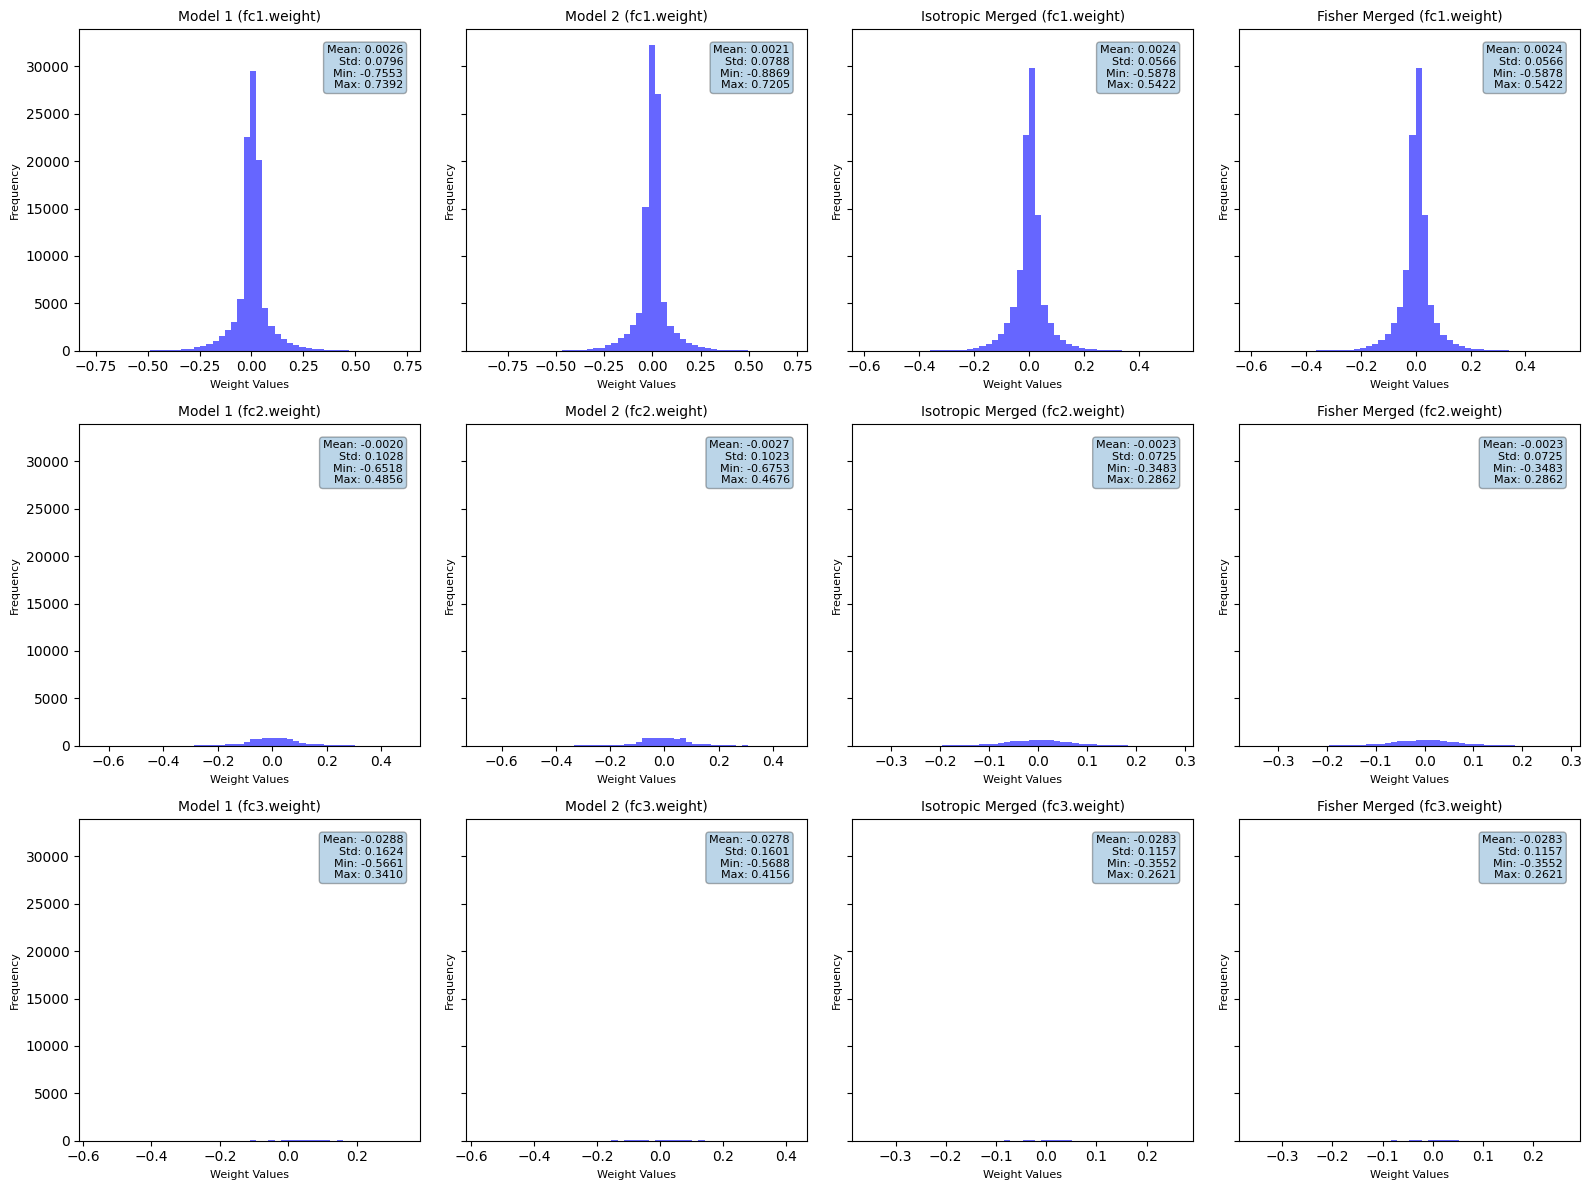

In [27]:
sys.argv = [
    'The impact of Fisher scaling on model performance. Impose isotropic merging for all layers (A preliminary step for next implementing layer specific fisher-merging)',
    '--command', 'train', 'merge', 'validate', 'visualize',
    '--dataset', 'mnist',
    '--model', 'mlp',
    '--epochs', '10',
    '--ablation', 'weighting', 'fisher_scaling',
    '--scaling_factor', '0.001',  '0.01',  '0.1' , '0.5', '1.0', '2.0', '5.0', '10.0'
]
main()

### Performing Fisher Scaling (Layer Specific Merging)

Training Model 1...
Training on cpu...
Epoch 1/10, Loss: 0.3802001322192678
Epoch 2/10, Loss: 0.1831852030823194
Epoch 3/10, Loss: 0.13318832447406834
Epoch 4/10, Loss: 0.10733856135077759
Epoch 5/10, Loss: 0.09062891140598049
Epoch 6/10, Loss: 0.0799685410067026
Epoch 7/10, Loss: 0.07061119631232161
Epoch 8/10, Loss: 0.06451895945496472
Epoch 9/10, Loss: 0.05755200990905632
Epoch 10/10, Loss: 0.05205781865211676
Training complete. Model moved to CPU.
Test Accuracy: 97.43%
Model saved at: saved_models/mnist_mlp_1.pth
Model saved at: mnist_mlp_1.pth
Training Model 2...
Training on cpu...
Epoch 1/10, Loss: 0.3928159580254224
Epoch 2/10, Loss: 0.1805543267140304
Epoch 3/10, Loss: 0.1308451254210715
Epoch 4/10, Loss: 0.10676302852680974
Epoch 5/10, Loss: 0.09114466752233441
Epoch 6/10, Loss: 0.08090744014712237
Epoch 7/10, Loss: 0.07121899296745046
Epoch 8/10, Loss: 0.061612839303187915
Epoch 9/10, Loss: 0.05897346414416643
Epoch 10/10, Loss: 0.05091311877803392
Training complete. Model mo

Computing Fisher Information: 100%|██████████| 938/938 [00:19<00:00, 46.95batch/s]


Computing Fisher Information for Model 2...


Computing Fisher Information: 100%|██████████| 938/938 [00:19<00:00, 48.81batch/s]


Running Fisher Scaling Experiment...
Testing Fisher Scaling Factor β = 0.001...


Merging Models: 6param [00:00, 3027.29param/s]
Validating Model: 100%|██████████| 157/157 [00:03<00:00, 43.91batch/s]


Accuracy for β = 0.001: 0.5497
Testing Fisher Scaling Factor β = 0.01...


Merging Models: 6param [00:00, 1838.26param/s]
Validating Model: 100%|██████████| 157/157 [00:03<00:00, 48.83batch/s]


Accuracy for β = 0.01: 0.5854
Testing Fisher Scaling Factor β = 0.1...


Merging Models: 6param [00:00, 3437.48param/s]
Validating Model: 100%|██████████| 157/157 [00:02<00:00, 56.44batch/s]


Accuracy for β = 0.1: 0.5908
Testing Fisher Scaling Factor β = 0.5...


Merging Models: 6param [00:00, 1980.94param/s]
Validating Model: 100%|██████████| 157/157 [00:02<00:00, 56.66batch/s]


Accuracy for β = 0.5: 0.5911
Testing Fisher Scaling Factor β = 1.0...


Merging Models: 6param [00:00, 1703.39param/s]
Validating Model: 100%|██████████| 157/157 [00:03<00:00, 51.23batch/s]


Accuracy for β = 1.0: 0.5908
Testing Fisher Scaling Factor β = 2.0...


Merging Models: 6param [00:00, 1473.06param/s]
Validating Model: 100%|██████████| 157/157 [00:03<00:00, 41.58batch/s]


Accuracy for β = 2.0: 0.5915
Testing Fisher Scaling Factor β = 5.0...


Merging Models: 6param [00:00, 1764.91param/s]
Validating Model: 100%|██████████| 157/157 [00:02<00:00, 56.40batch/s]


Accuracy for β = 5.0: 0.5916
Testing Fisher Scaling Factor β = 10.0...


Merging Models: 6param [00:00, 3089.73param/s]
Validating Model: 100%|██████████| 157/157 [00:02<00:00, 56.50batch/s]


Accuracy for β = 10.0: 0.5915

Best Fisher Scaling Factor: β = 5.0 with Accuracy: 0.5916


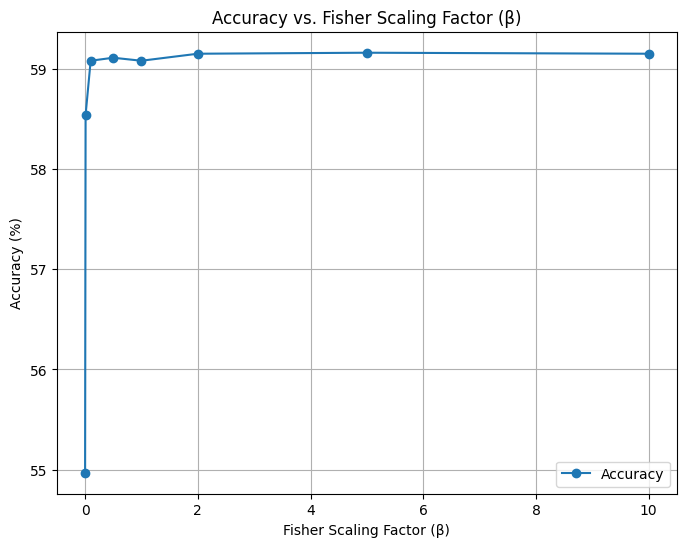

Merging models using Fisher-weighted averaging...


Merging Models: 6param [00:00, 3276.37param/s]


Model saved at: saved_models/mnist_mlp_fisher_merged.pth
Fisher-merged model saved at: mnist_mlp_fisher_merged.pth
Model saved at: saved_models/mnist_mlp_fisher_merged.pth
Fisher merged model saved: ['mnist']_mlp_fisher_merged.pth
Merging using isotropic averaging...
Model saved at: saved_models/mnist_mlp_isotropic_merged.pth
Isotropic merged model saved: ['mnist']_mlp_isotropic_merged.pth
Merging using output ensembling...
Model saved at: saved_models/mnist_mlp_ensemble_merged.pth
Ensemble merged model saved: ['mnist']_mlp_ensemble_merged.pth
Validating Model 1...


Validating Model: 100%|██████████| 157/157 [00:02<00:00, 56.10batch/s]


Validating Model 2...


Validating Model: 100%|██████████| 157/157 [00:03<00:00, 39.83batch/s]


Validating fisher Merged Model...


Validating Model: 100%|██████████| 157/157 [00:02<00:00, 56.91batch/s]


Validating isotropic Merged Model...


Validating Model: 100%|██████████| 157/157 [00:02<00:00, 56.68batch/s]


Validating ensemble Merged Model...


Validating Model: 100%|██████████| 157/157 [00:02<00:00, 54.70batch/s]


Validation results:
model1: {'loss': 0.08304988116403718, 'accuracy': 0.9743, 'f1_score': 0.9742819280949548, 'precision': 0.9744118235681668, 'recall': 0.9743}
model2: {'loss': 0.08150309124129348, 'accuracy': 0.9755, 'f1_score': 0.9754741349762777, 'precision': 0.9755769265678657, 'recall': 0.9755}
fisher: {'loss': 1.2107162718560285, 'accuracy': 0.5916, 'f1_score': 0.5709981584680514, 'precision': 0.7314566053024322, 'recall': 0.5916}
isotropic: {'loss': 1.0789075178705203, 'accuracy': 0.6979, 'f1_score': 0.70003696883258, 'precision': 0.7812337805990748, 'recall': 0.6979}
ensemble: {'loss': 0.06401025567876763, 'accuracy': 0.9796, 'f1_score': 0.9795874929720536, 'precision': 0.9796462392201968, 'recall': 0.9796}
Generating comparison chart...
Generating comparison charts for a single dataset...


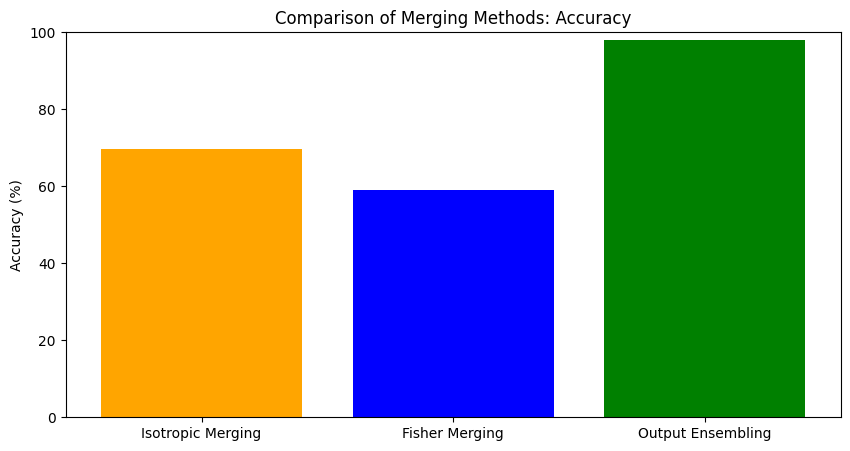

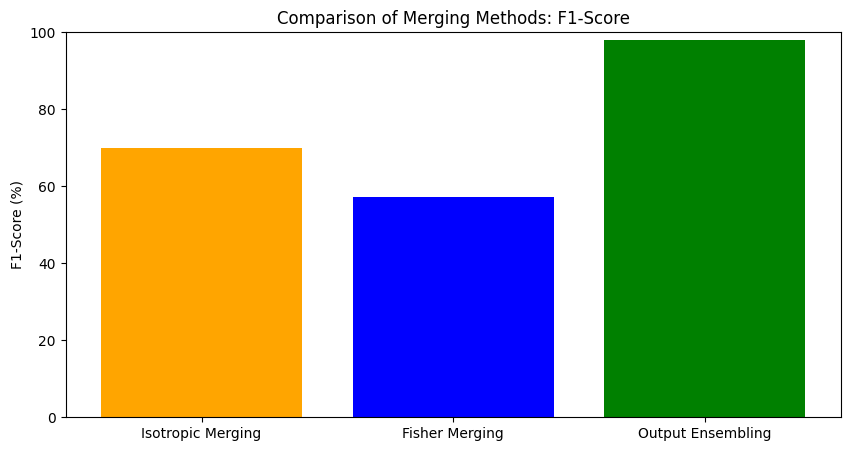

Plotting layer distributions...


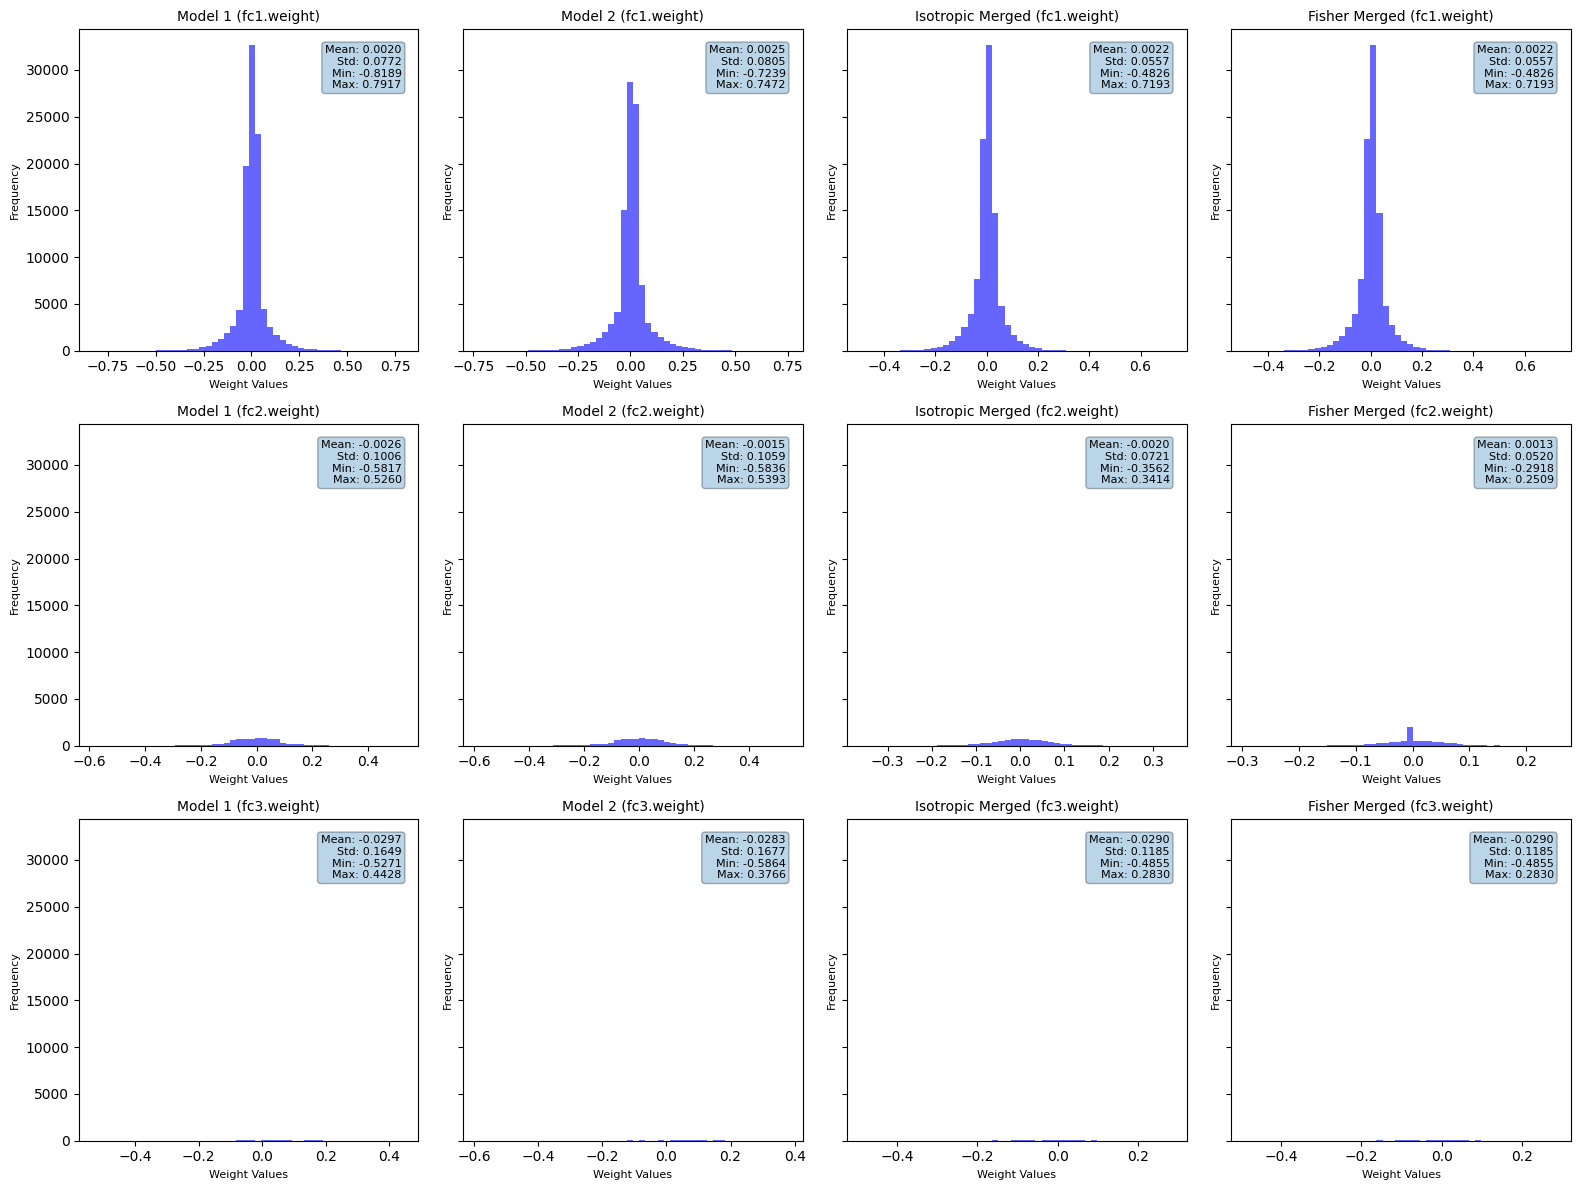

In [32]:
sys.argv = [
    'The impact of Fisher scaling on model performance. Impose isotropic merging for all layers (A preliminary step for next implementing layer specific fisher-merging)',
    '--command', 'train', 'merge', 'validate', 'visualize',
    '--dataset', 'mnist',
    '--model', 'mlp',
    '--epochs', '10',
    '--ablation', 'fisher_scaling', 'layer_specific',
    '--scaling_factor', '0.001',  '0.01',  '0.1' , '0.5', '1.0', '2.0', '5.0', '10.0',
    '--layers','fc2.weight'
]
main()

Training Model 1...
Training on cpu...
Epoch 1/10, Loss: 0.39492806029726446
Epoch 2/10, Loss: 0.18150179457864654
Epoch 3/10, Loss: 0.1319506596754005
Epoch 4/10, Loss: 0.10976253672322231
Epoch 5/10, Loss: 0.09384707933185554
Epoch 6/10, Loss: 0.08110187183678357
Epoch 7/10, Loss: 0.07109434127848326
Epoch 8/10, Loss: 0.06368199043295611
Epoch 9/10, Loss: 0.058626151313312225
Epoch 10/10, Loss: 0.05184330113097104
Training complete. Model moved to CPU.
Test Accuracy: 97.12%
Model saved at: saved_models/mnist_mlp_1.pth
Model saved at: mnist_mlp_1.pth
Training Model 2...
Training on cpu...
Epoch 1/10, Loss: 0.38196835879371493
Epoch 2/10, Loss: 0.1883767584541332
Epoch 3/10, Loss: 0.13495041404380156
Epoch 4/10, Loss: 0.11056605301130173
Epoch 5/10, Loss: 0.09680178175285173
Epoch 6/10, Loss: 0.08220939395843999
Epoch 7/10, Loss: 0.07220400502778161
Epoch 8/10, Loss: 0.06639239262999978
Epoch 9/10, Loss: 0.05893804936936355
Epoch 10/10, Loss: 0.05391385754049599
Training complete. Mode

Computing Fisher Information: 100%|██████████| 938/938 [00:20<00:00, 46.13batch/s]


Computing Fisher Information for Model 2...


Computing Fisher Information: 100%|██████████| 938/938 [00:19<00:00, 48.86batch/s]


Running Fisher Scaling Experiment...
Testing Fisher Scaling Factor β = 0.001...


Merging Models: 6param [00:00, 1505.85param/s]
Validating Model: 100%|██████████| 157/157 [00:03<00:00, 49.56batch/s]


Accuracy for β = 0.001: 0.4759
Testing Fisher Scaling Factor β = 0.01...


Merging Models: 6param [00:00, 1056.19param/s]
Validating Model: 100%|██████████| 157/157 [00:03<00:00, 43.68batch/s]


Accuracy for β = 0.01: 0.6215
Testing Fisher Scaling Factor β = 0.1...


Merging Models: 6param [00:00, 2615.72param/s]
Validating Model: 100%|██████████| 157/157 [00:02<00:00, 55.39batch/s]


Accuracy for β = 0.1: 0.6417
Testing Fisher Scaling Factor β = 0.5...


Merging Models: 6param [00:00, 2408.67param/s]
Validating Model: 100%|██████████| 157/157 [00:02<00:00, 55.96batch/s]


Accuracy for β = 0.5: 0.6428
Testing Fisher Scaling Factor β = 1.0...


Merging Models: 6param [00:00, 2128.91param/s]
Validating Model: 100%|██████████| 157/157 [00:02<00:00, 56.17batch/s]


Accuracy for β = 1.0: 0.6434
Testing Fisher Scaling Factor β = 2.0...


Merging Models: 6param [00:00, 1264.42param/s]
Validating Model: 100%|██████████| 157/157 [00:03<00:00, 40.36batch/s]


Accuracy for β = 2.0: 0.6436
Testing Fisher Scaling Factor β = 5.0...


Merging Models: 6param [00:00, 1718.27param/s]
Validating Model: 100%|██████████| 157/157 [00:02<00:00, 56.99batch/s]


Accuracy for β = 5.0: 0.6437
Testing Fisher Scaling Factor β = 10.0...


Merging Models: 6param [00:00, 1806.59param/s]
Validating Model: 100%|██████████| 157/157 [00:02<00:00, 56.08batch/s]


Accuracy for β = 10.0: 0.6437

Best Fisher Scaling Factor: β = 5.0 with Accuracy: 0.6437


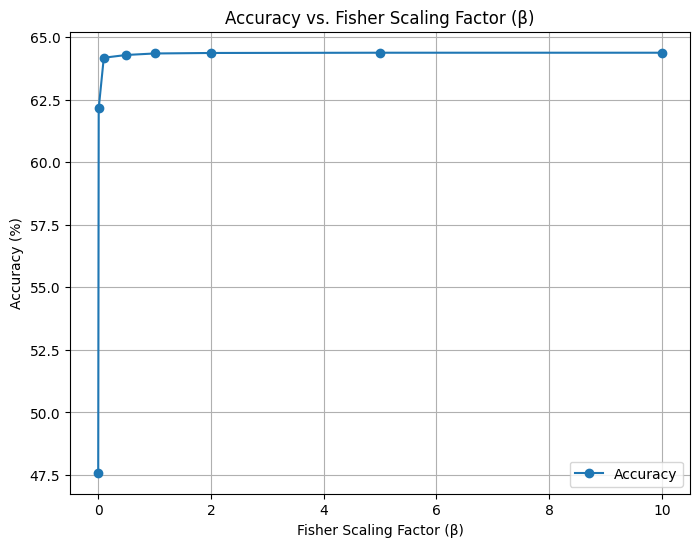

Merging models using Fisher-weighted averaging...


Merging Models: 6param [00:00, 2001.42param/s]


Model saved at: saved_models/mnist_mlp_fisher_merged.pth
Fisher-merged model saved at: mnist_mlp_fisher_merged.pth
Model saved at: saved_models/mnist_mlp_fisher_merged.pth
Fisher merged model saved: ['mnist']_mlp_fisher_merged.pth
Merging using isotropic averaging...
Model saved at: saved_models/mnist_mlp_isotropic_merged.pth
Isotropic merged model saved: ['mnist']_mlp_isotropic_merged.pth
Merging using output ensembling...
Model saved at: saved_models/mnist_mlp_ensemble_merged.pth
Ensemble merged model saved: ['mnist']_mlp_ensemble_merged.pth
Validating Model 1...


Validating Model: 100%|██████████| 157/157 [00:02<00:00, 56.99batch/s]


Validating Model 2...


Validating Model: 100%|██████████| 157/157 [00:03<00:00, 44.77batch/s]


Validating fisher Merged Model...


Validating Model: 100%|██████████| 157/157 [00:03<00:00, 48.79batch/s]


Validating isotropic Merged Model...


Validating Model: 100%|██████████| 157/157 [00:02<00:00, 56.76batch/s]


Validating ensemble Merged Model...


Validating Model: 100%|██████████| 157/157 [00:02<00:00, 54.06batch/s]


Validation results:
model1: {'loss': 0.10001712706133539, 'accuracy': 0.9712, 'f1_score': 0.9712336391819743, 'precision': 0.9715577090189695, 'recall': 0.9712}
model2: {'loss': 0.0899367998709593, 'accuracy': 0.9717, 'f1_score': 0.971680138132204, 'precision': 0.9718303364249771, 'recall': 0.9717}
fisher: {'loss': 1.1458405438502124, 'accuracy': 0.6437, 'f1_score': 0.6212067341775893, 'precision': 0.7933464010891721, 'recall': 0.6437}
isotropic: {'loss': 1.211772075124607, 'accuracy': 0.582, 'f1_score': 0.5573894223872776, 'precision': 0.7620408960481725, 'recall': 0.582}
ensemble: {'loss': 0.07080490848713719, 'accuracy': 0.9772, 'f1_score': 0.9771993313621821, 'precision': 0.977271018367515, 'recall': 0.9772}
Generating comparison chart...
Generating comparison charts for a single dataset...


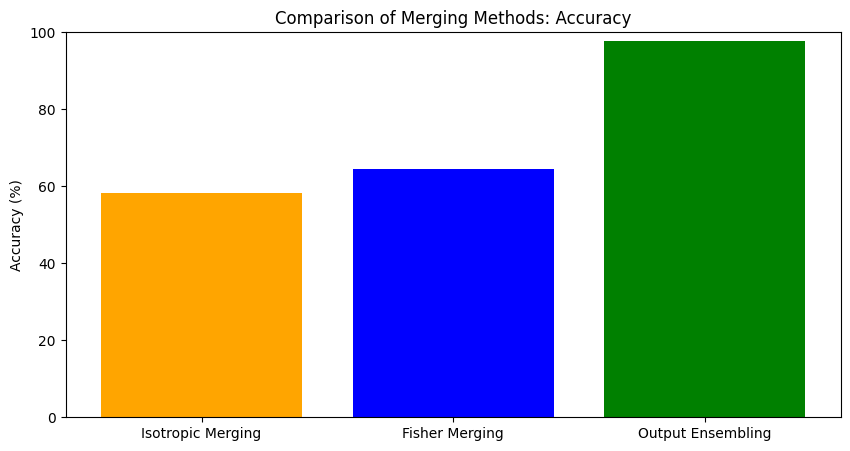

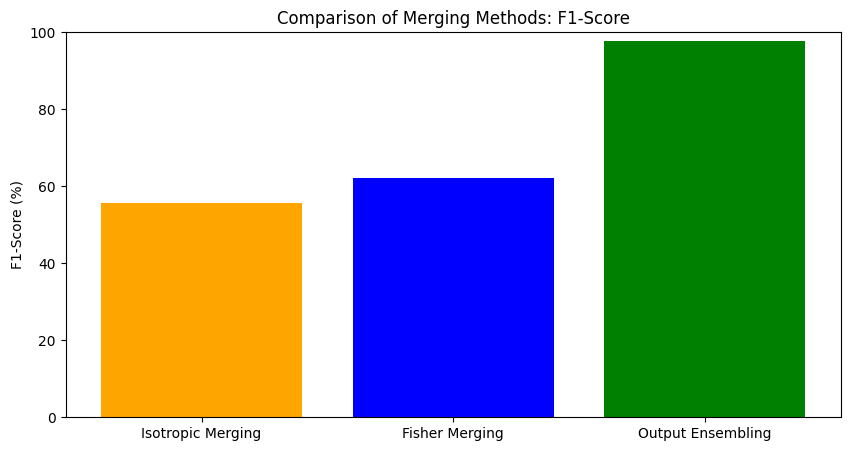

Plotting layer distributions...


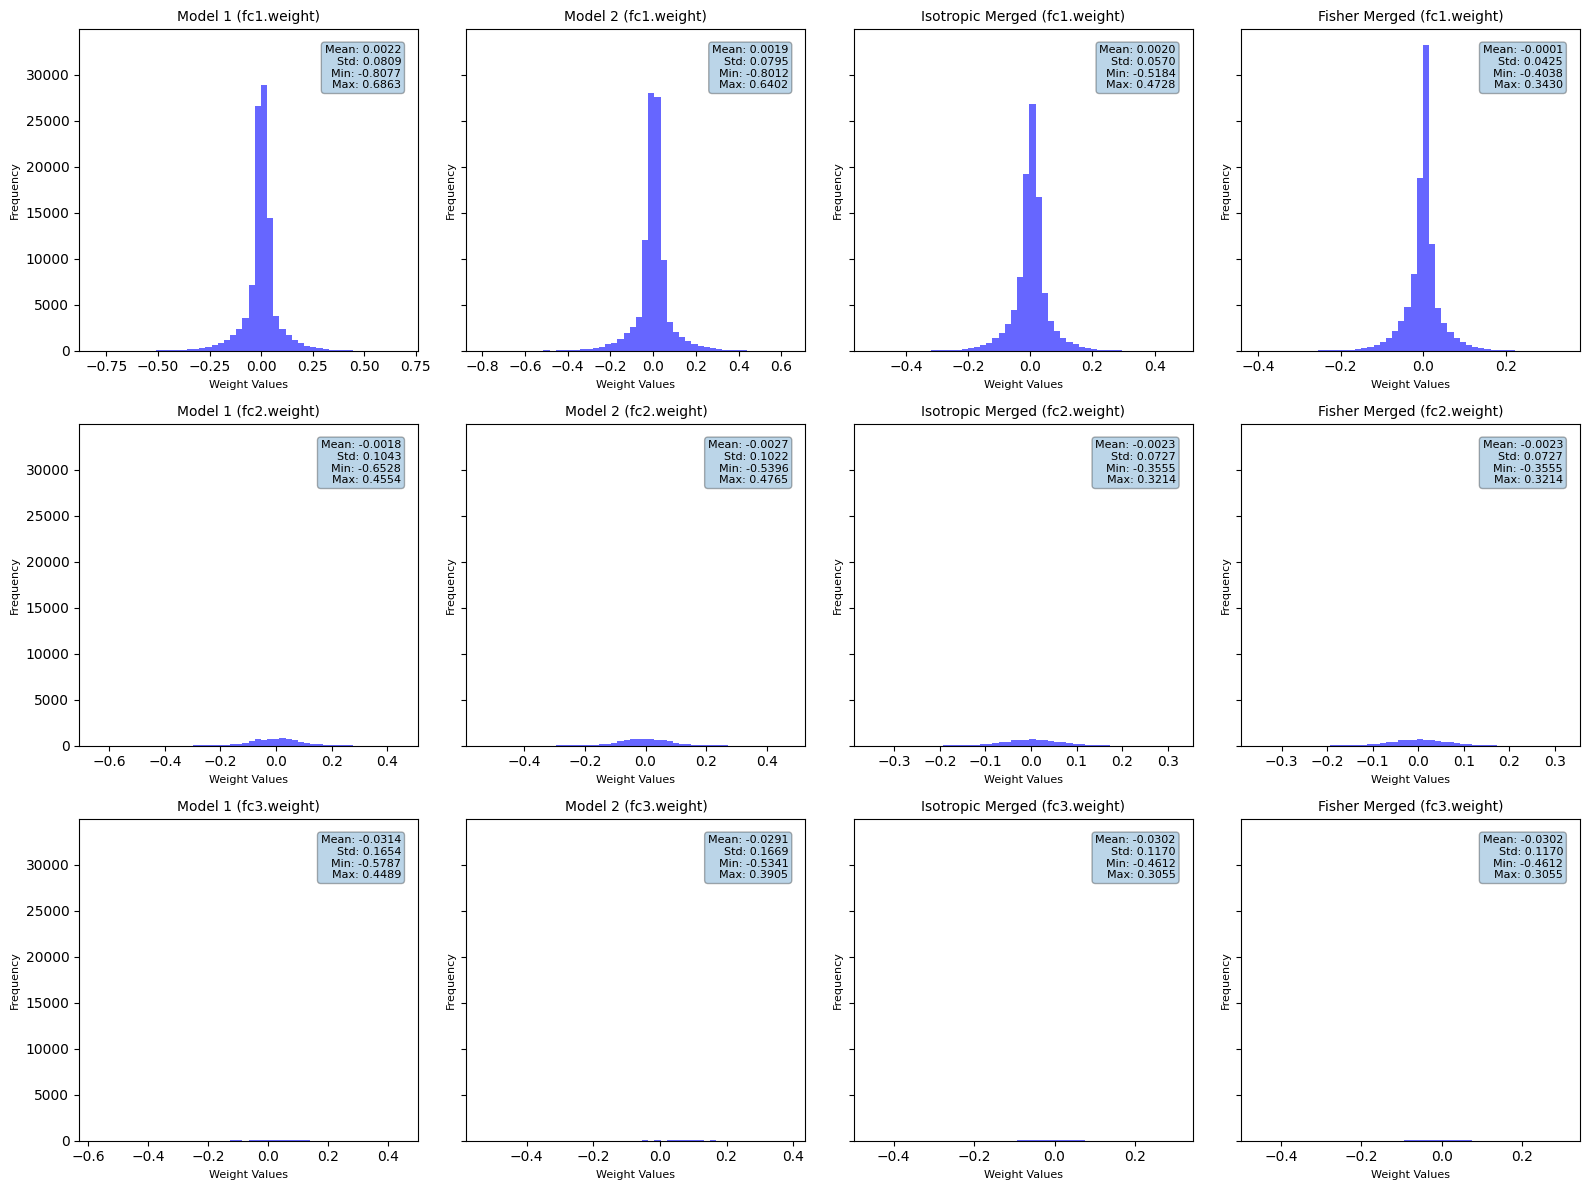

In [33]:
sys.argv = [
    'The impact of Fisher scaling on model performance. Impose isotropic merging for all layers (A preliminary step for next implementing layer specific fisher-merging)',
    '--command', 'train', 'merge', 'validate', 'visualize',
    '--dataset', 'mnist',
    '--model', 'mlp',
    '--epochs', '10',
    '--ablation', 'fisher_scaling', 'layer_specific',
    '--scaling_factor', '0.001',  '0.01',  '0.1' , '0.5', '1.0', '2.0', '5.0', '10.0',
    '--layers','fc1.weight'
]
main()